#   Optics Clustering

In [10]:
#IMPORTS
import yfinance as yf
import pandas as pd
import pandas_ta_classic as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS
from statsmodels.tsa.stattools import coint, grangercausalitytests
import warnings
import itertools
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
import pykalman as KalmanFilter
warnings.filterwarnings("ignore")

# Data Fetch

In [3]:
# Data
stocks = [
    # S&P for Beta
    "^GSPC",
    # Megacap Leaders & Generalists
    "NVDA", "TSM", "AVGO", "AMD", "INTC", "MU", "TXN", "QCOM", "ADI", "MCHP",
    
    # Equipment & Manufacturing
    "ASML", "AMAT", "LRCX", "KLAC", "TER", "ENTG", "NVMI", "TOELY",
    
    # Specialized
    "ON", "NXPI", "STM", "LSCC", "MPWR", "QRVO", "SWKS", "ALAB", "CRDO",
    
    # Intellectual Property & Design Software
    "ARM", "SNPS", "CDNS", "CEVA",
    
    # Memory & Storage
    "WDC", "STX", # Removed extra "MU" here
    
    # Emerging & Mid-Cap
    "GFS", "MRVL", "MTSI", "POWI", "SMTC", "VICR", "CAMT"
]

def fetch_data(stocks):
    data = yf.download(tickers=stocks, period="252d", interval="1h", group_by='ticker', auto_adjust=True, threads=True)
    
    price_series_list = []
    for s in stocks:
        try: 
            if s in data:
                series = data[s]['Close']
                series.name = s
                price_series_list.append(series)
        except Exception as e:
            pass

    if price_series_list:
        df = pd.concat(price_series_list, axis=1)
        df = df.ffill() 
        return df
    return pd.DataFrame()

df = fetch_data(stocks)

[*********************100%***********************]  41 of 41 completed


## Factor Data Preparation

In [6]:
# ============================================================================
# FEATURE ENGINEERING FOR TRANSIENT REGIME DETECTION
# ============================================================================

# 1. Clean and Prepare Price Data
if isinstance(df.columns, pd.MultiIndex):
    if 'Close' in df.columns.get_level_values(0):
        df = df['Close']
    elif 'Close' in df.columns.get_level_values(1):
        df = df.xs('Close', axis=1, level=1)

# 2. Base Calculations
returns_df = df.pct_change().dropna()
market_returns = returns_df['^GSPC']

# ============================================================================
# CRITICAL CHANGE: Multi-Timeframe Feature Engineering
# ============================================================================

# SHORT-TERM WINDOW (Transient regime detection)
window_short = 50  # ~1 week of hourly data - ALIGNED WITH TRADE DURATION

# MEDIUM-TERM WINDOW (Context/stability check)
window_medium = 147  # ~3 weeks - your original window

print("="*80)
print("FEATURE ENGINEERING - MULTI-TIMEFRAME APPROACH")
print("="*80)
print(f"Short-term window: {window_short} hours (~1 week)")
print(f"Medium-term window: {window_medium} hours (~3 weeks)")
print(f"Optimizing for transient events: 10-50 hour duration\n")


# ============================================================================
# 3A. SHORT-TERM FEATURES (Primary clustering features)
# ============================================================================

print("Calculating SHORT-TERM features (primary regime indicators)...")

# Feature A: SHORT-TERM Volatility (Recent risk behavior)
rolling_vol_short = returns_df.rolling(window=window_short).std() * np.sqrt(252 * 7)

# Feature B: SHORT-TERM Beta to SPX (Recent market sensitivity)
rolling_cov_mkt_short = returns_df.rolling(window=window_short).cov(market_returns)
rolling_mkt_var_short = market_returns.rolling(window=window_short).var()
rolling_beta_spx_short = rolling_cov_mkt_short.divide(rolling_mkt_var_short, axis=0)

# Feature C: SHORT-TERM Beta to Sector (Recent sector coupling)
sector_returns = returns_df.drop(columns=['^GSPC'], errors='ignore').mean(axis=1)
rolling_cov_sector_short = returns_df.rolling(window=window_short).cov(sector_returns)
rolling_sector_var_short = sector_returns.rolling(window=window_short).var()
rolling_beta_sector_short = rolling_cov_sector_short.divide(rolling_sector_var_short, axis=0)


# ============================================================================
# 3B. MEDIUM-TERM FEATURES (Context/stability indicators)
# ============================================================================

print("Calculating MEDIUM-TERM features (context indicators)...")

# These help identify if current behavior is unusual vs. longer-term baseline
rolling_vol_medium = returns_df.rolling(window=window_medium).std() * np.sqrt(252 * 7)

rolling_cov_mkt_medium = returns_df.rolling(window=window_medium).cov(market_returns)
rolling_mkt_var_medium = market_returns.rolling(window=window_medium).var()
rolling_beta_spx_medium = rolling_cov_mkt_medium.divide(rolling_mkt_var_medium, axis=0)

rolling_cov_sector_medium = returns_df.rolling(window=window_medium).cov(sector_returns)
rolling_sector_var_medium = sector_returns.rolling(window=window_medium).var()
rolling_beta_sector_medium = rolling_cov_sector_medium.divide(rolling_sector_var_medium, axis=0)


# ============================================================================
# 3C. INSTANTANEOUS FEATURES (Momentum/Overbought indicators)
# ============================================================================

print("Calculating INSTANTANEOUS features (momentum indicators)...")

# Feature D: RSI (Momentum/Overextended) - Keep at 14 (standard)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

rsi_df = df.apply(calculate_rsi)

# Feature E: Short Term Momentum (5-period return)
momentum_5h = df.pct_change(periods=5)

# Feature F: Momentum Acceleration (change in momentum)
momentum_10h = df.pct_change(periods=10)
momentum_acceleration = momentum_5h - momentum_10h


# ============================================================================
# 3D. REGIME CHANGE INDICATORS (New!)
# ============================================================================

print("Calculating REGIME CHANGE indicators...")

# Detect when short-term behavior diverges from medium-term baseline
# This helps identify when a NEW regime is forming

# Volatility Regime Shift (is vol spiking vs. baseline?)
vol_regime_shift = (rolling_vol_short - rolling_vol_medium) / rolling_vol_medium

# Beta Regime Shift (is market sensitivity changing?)
beta_spx_regime_shift = rolling_beta_spx_short - rolling_beta_spx_medium
beta_sector_regime_shift = rolling_beta_sector_short - rolling_beta_sector_medium


# ============================================================================
# 4. Assemble the Master Time-Series DataFrame (ts_df)
# ============================================================================

print("\nAssembling time-series dataframe...")

ts_data_list = []

for ticker in stocks:
    if ticker == '^GSPC' or ticker not in df.columns: 
        continue
    
    # Extract features for this specific ticker
    temp_df = pd.DataFrame({
        # Price & Returns (baseline)
        'Price': df[ticker],
        'Returns': returns_df[ticker],
        
        # SHORT-TERM FEATURES (Primary clustering features)
        'Vol_Short': rolling_vol_short[ticker],
        'Beta_SPX_Short': rolling_beta_spx_short[ticker],
        'Beta_Sector_Short': rolling_beta_sector_short[ticker],
        
        # MEDIUM-TERM FEATURES (Context)
        'Vol_Medium': rolling_vol_medium[ticker],
        'Beta_SPX_Medium': rolling_beta_spx_medium[ticker],
        'Beta_Sector_Medium': rolling_beta_sector_medium[ticker],
        
        # INSTANTANEOUS FEATURES
        'RSI': rsi_df[ticker],
        'Momentum_5H': momentum_5h[ticker],
        'Momentum_10H': momentum_10h[ticker],
        'Momentum_Accel': momentum_acceleration[ticker],
        
        # REGIME CHANGE INDICATORS (New!)
        'Vol_Regime_Shift': vol_regime_shift[ticker],
        'Beta_SPX_Regime_Shift': beta_spx_regime_shift[ticker],
        'Beta_Sector_Regime_Shift': beta_sector_regime_shift[ticker],
        
    }, index=df.index)
    
    temp_df['Ticker'] = ticker
    ts_data_list.append(temp_df)

if ts_data_list:
    ts_df = pd.concat(ts_data_list).reset_index().set_index(['Datetime', 'Ticker'])
    
    # Drop NaNs created by rolling windows
    initial_rows = len(ts_df)
    ts_df = ts_df.dropna()
    dropped_rows = initial_rows - len(ts_df)
    
    print(f"\n{'='*80}")
    print("TIME-SERIES DATAFRAME CREATED SUCCESSFULLY")
    print(f"{'='*80}")
    print(f"Total rows: {len(ts_df):,}")
    print(f"Rows dropped (NaN): {dropped_rows:,} ({dropped_rows/initial_rows:.1%})")
    print(f"Date range: {ts_df.index.get_level_values('Datetime').min()} to {ts_df.index.get_level_values('Datetime').max()}")
    print(f"Unique tickers: {ts_df.index.get_level_values('Ticker').nunique()}")
    print(f"\nFeature columns: {len([c for c in ts_df.columns if c not in ['Price', 'Returns', 'Ticker']])}")
    print("\nSample data:")
    print(ts_df.head())


# ============================================================================
# 5. OPTIONAL: Static Fundamental DataFrame (Keep or Remove?)
# ============================================================================

# NOTE: For transient regime detection, fundamentals are less relevant
# Transient coupling is driven by events/news, not fundamental similarity
# Consider REMOVING this section unless you plan to use it for filtering

print(f"\n{'='*80}")
print("SKIPPING STATIC FUNDAMENTALS (Not relevant for transient detection)")
print(f"{'='*80}")
print("Transient coupling is driven by events/market dynamics, not fundamental profiles.")
print("If you want to filter pairs by fundamentals later, re-enable this section.\n")

# Uncomment below if you want to keep fundamentals
"""
fundamental_list = []
print("Fetching Static Fundamentals...")

for ticker in stocks:
    if ticker == '^GSPC': continue
    try:
        t = yf.Ticker(ticker)
        info = t.info
        
        fundamental_list.append({
            'Ticker': ticker,
            'Sector': info.get('sector', 'Unknown'),
            'Industry': info.get('industry', 'Unknown'),
            'Market_Cap': info.get('marketCap', np.nan),
        })
    except Exception as e:
        print(f"Could not fetch data for {ticker}: {e}")
        continue

static_df = pd.DataFrame(fundamental_list).set_index('Ticker')
print("Static DataFrame (static_df) Created Successfully!")
"""

print("="*80)
print("FEATURE ENGINEERING COMPLETE - Ready for clustering")
print("="*80)

FEATURE ENGINEERING - MULTI-TIMEFRAME APPROACH
Short-term window: 50 hours (~1 week)
Medium-term window: 147 hours (~3 weeks)
Optimizing for transient events: 10-50 hour duration

Calculating SHORT-TERM features (primary regime indicators)...
Calculating MEDIUM-TERM features (context indicators)...
Calculating INSTANTANEOUS features (momentum indicators)...
Calculating REGIME CHANGE indicators...

Assembling time-series dataframe...

TIME-SERIES DATAFRAME CREATED SUCCESSFULLY
Total rows: 64,320
Rows dropped (NaN): 5,880 (8.4%)
Date range: 2025-03-10 13:30:00+00:00 to 2026-02-06 20:30:00+00:00
Unique tickers: 40

Feature columns: 13

Sample data:
                                       Price   Returns  Vol_Short  \
Datetime                  Ticker                                    
2025-03-10 13:30:00+00:00 NVDA    108.064400 -0.041387   0.689006   
2025-03-10 14:30:00+00:00 NVDA    107.658203 -0.003759   0.669402   
2025-03-10 15:30:00+00:00 NVDA    108.084999  0.003964   0.669683   
2

# Clustering

## Based on an Hourly Time Frame

In [9]:
# ============================================================================
# OPTICS CLUSTERING FOR TRANSIENT REGIME DETECTION
# ============================================================================

if 'ts_df' not in locals():
    raise ValueError("Please run the Feature Engineering cell to create 'ts_df' first.")

# Clean duplicates
ts_df = ts_df[~ts_df.index.duplicated(keep='first')]

# Check Density
density = ts_df.groupby(level='Datetime').size()
valid_timestamps = density[density >= 5].index

print(f"{'='*80}")
print(f"TRANSIENT REGIME DETECTION - OPTICS CLUSTERING")
print(f"{'='*80}")
print(f"Data Density: {len(valid_timestamps)} valid hourly timestamps")
print(f"Date Range: {valid_timestamps.min()} to {valid_timestamps.max()}")

# ============================================================================
# USE EXISTING FEATURES (Your current column names)
# ============================================================================
features_to_cluster = ['Returns', 'Rolling_Vol', 'Beta_SPX', 'Beta_Sector', 'RSI', 'Momentum_5H']
print(f"\nUsing features: {features_to_cluster}")

# ============================================================================
# CLUSTERING LOOP - Hourly Regime Detection
# ============================================================================

print(f"\n{'='*80}")
print("PHASE 1: Running OPTICS Clustering (Hourly Snapshots)")
print(f"{'='*80}")

cluster_results = []
cluster_quality_log = []

for i, ts in enumerate(valid_timestamps):
    try:
        snapshot = ts_df.xs(ts, level='Datetime')[features_to_cluster].dropna()
        if len(snapshot) < 5: 
            continue
        
        # Scale & PCA (Dimensionality Reduction)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(snapshot)
        
        pca = PCA(n_components=0.90)
        X_pca = pca.fit_transform(X_scaled)
        
        # OPTICS Clustering
        optics = OPTICS(min_samples=3, metric='euclidean', xi=0.05, min_cluster_size=3)
        optics.fit(X_pca)
        
        # ===== CLUSTER QUALITY VALIDATION (RELAXED) =====
        unique_clusters = len(set(optics.labels_)) - (1 if -1 in optics.labels_ else 0)
        noise_count = (optics.labels_ == -1).sum()
        noise_pct = noise_count / len(optics.labels_)
        total_stocks = len(optics.labels_)
        
        # Quality Metrics
        quality_metrics = {
            'Datetime': ts,
            'Total_Stocks': total_stocks,
            'Unique_Clusters': unique_clusters,
            'Noise_Count': noise_count,
            'Noise_Pct': noise_pct,
            'PCA_Components': X_pca.shape[1],
            'Variance_Explained': pca.explained_variance_ratio_.sum()
        }
        
        # RELAXED Quality Filters
        is_valid = True
        skip_reason = None
        
        if unique_clusters < 1:
            is_valid = False
            skip_reason = "No clusters found (all noise)"
        elif noise_pct > 0.75:  # Relaxed to 75%
            is_valid = False
            skip_reason = f"Too noisy ({noise_pct:.1%} noise)"
        elif unique_clusters > total_stocks * 0.75:
            is_valid = False
            skip_reason = f"Over-fragmented ({unique_clusters} clusters for {total_stocks} stocks)"
        
        quality_metrics['Is_Valid'] = is_valid
        quality_metrics['Skip_Reason'] = skip_reason
        cluster_quality_log.append(quality_metrics)
        
        # Store valid clusters
        if is_valid:
            snapshot['Cluster_ID'] = optics.labels_
            snapshot['Datetime'] = ts
            snapshot['Num_Clusters'] = unique_clusters
            snapshot['Noise_Pct'] = noise_pct
            cluster_results.append(snapshot.reset_index())
        
        # Progress indicator
        if (i + 1) % 100 == 0:
            valid_so_far = len(cluster_results)
            print(f"  Processed {i+1}/{len(valid_timestamps)} timestamps... ({valid_so_far} valid so far)")
            
    except Exception as e:
        cluster_quality_log.append({
            'Datetime': ts,
            'Is_Valid': False,
            'Skip_Reason': f"Error: {str(e)[:50]}"
        })
        continue

if not cluster_results:
    raise ValueError("No valid clusters found. Check your data quality and OPTICS parameters.")

cluster_history = pd.concat(cluster_results, ignore_index=True)

print(f"\n{'='*80}")
print("PHASE 1 COMPLETE: Cluster Quality Summary")
print(f"{'='*80}")

# ============================================================================
# CLUSTER QUALITY ANALYSIS
# ============================================================================

df_quality = pd.DataFrame(cluster_quality_log)

total_timestamps = len(df_quality)
valid_timestamps_count = df_quality['Is_Valid'].sum()
invalid_timestamps_count = total_timestamps - valid_timestamps_count

print(f"\nTimestamp Analysis:")
print(f"  Total timestamps processed: {total_timestamps}")
print(f"  Valid clustering windows: {valid_timestamps_count} ({valid_timestamps_count/total_timestamps:.1%})")
print(f"  Invalid/skipped windows: {invalid_timestamps_count} ({invalid_timestamps_count/total_timestamps:.1%})")

if invalid_timestamps_count > 0:
    print(f"\nSkip Reasons:")
    skip_summary = df_quality[~df_quality['Is_Valid']]['Skip_Reason'].value_counts()
    for reason, count in skip_summary.items():
        print(f"  - {reason}: {count} ({count/invalid_timestamps_count:.1%})")

# Valid cluster statistics
valid_quality = df_quality[df_quality['Is_Valid']]
if len(valid_quality) > 0:
    print(f"\nValid Cluster Statistics:")
    print(f"  Avg clusters per timestamp: {valid_quality['Unique_Clusters'].mean():.1f}")
    print(f"  Avg noise percentage: {valid_quality['Noise_Pct'].mean():.1%}")
    print(f"  Avg PCA variance retained: {valid_quality['Variance_Explained'].mean():.1%}")

print(f"\nCluster History Generated:")
print(f"  Total rows: {len(cluster_history)}")
print(f"  Unique timestamps: {cluster_history['Datetime'].nunique()}")
print(f"  Date range: {cluster_history['Datetime'].min()} to {cluster_history['Datetime'].max()}")


# ============================================================================
# PHASE 2: Cluster Stability Analysis
# ============================================================================

print(f"\n{'='*80}")
print("PHASE 2: Analyzing Cluster Stability")
print(f"{'='*80}")

pair_co_cluster_freq = {}

for ts in cluster_history['Datetime'].unique():
    snapshot = cluster_history[cluster_history['Datetime'] == ts]
    
    for cluster_id in snapshot['Cluster_ID'].unique():
        if cluster_id == -1:
            continue
        
        members = snapshot[snapshot['Cluster_ID'] == cluster_id]['Ticker'].tolist()
        
        for s1, s2 in itertools.combinations(sorted(members), 2):
            pair_key = (s1, s2)
            
            if pair_key not in pair_co_cluster_freq:
                pair_co_cluster_freq[pair_key] = 0
            pair_co_cluster_freq[pair_key] += 1

# Calculate frequencies
total_valid_windows = cluster_history['Datetime'].nunique()

pair_stability_data = []
for pair, count in pair_co_cluster_freq.items():
    frequency = count / total_valid_windows
    pair_stability_data.append({
        'Ticker_1': pair[0],
        'Ticker_2': pair[1],
        'Pair': f"{pair[0]}-{pair[1]}",
        'Co_Cluster_Count': count,
        'Co_Cluster_Frequency': frequency,
        'Is_Stable': frequency > 0.30
    })

df_pair_stability = pd.DataFrame(pair_stability_data).sort_values('Co_Cluster_Frequency', ascending=False)

print(f"\nPair Clustering Analysis:")
print(f"  Total unique pairs observed: {len(df_pair_stability)}")
print(f"  Pairs clustered together >50% of time: {(df_pair_stability['Co_Cluster_Frequency'] > 0.50).sum()}")
print(f"  Pairs clustered together >30% of time: {(df_pair_stability['Co_Cluster_Frequency'] > 0.30).sum()}")
print(f"  Pairs clustered together <10% of time: {(df_pair_stability['Co_Cluster_Frequency'] < 0.10).sum()}")

print(f"\n{'='*80}")
print("TOP 15 MOST FREQUENTLY CO-CLUSTERED PAIRS")
print(f"{'='*80}")
print(df_pair_stability[['Pair', 'Co_Cluster_Count', 'Co_Cluster_Frequency']].head(15).to_string(index=False))

print(f"\n{'='*80}")
print("TOP 15 MOST TRANSIENT PAIRS (Rare Co-Clustering)")
print(f"{'='*80}")
transient_pairs = df_pair_stability[
    (df_pair_stability['Co_Cluster_Frequency'] > 0.05) &
    (df_pair_stability['Co_Cluster_Frequency'] < 0.20)
].sort_values('Co_Cluster_Frequency', ascending=True)
print(transient_pairs[['Pair', 'Co_Cluster_Count', 'Co_Cluster_Frequency']].head(15).to_string(index=False))


# ============================================================================
# PHASE 3: Temporal Analysis
# ============================================================================

print(f"\n{'='*80}")
print("PHASE 3: Temporal Analysis - When Do Regimes Shift?")
print(f"{'='*80}")

cluster_history['Date'] = pd.to_datetime(cluster_history['Datetime']).dt.date

daily_cluster_stats = cluster_history.groupby('Date').agg({
    'Cluster_ID': lambda x: len(set(x)) - (1 if -1 in x.values else 0),
    'Ticker': 'count'
}).rename(columns={'Cluster_ID': 'Num_Clusters', 'Ticker': 'Total_Obs'})

print(f"\nDaily Clustering Variability:")
print(f"  Days with high differentiation (>4 clusters): {(daily_cluster_stats['Num_Clusters'] > 4).sum()}")
print(f"  Days with low differentiation (≤2 clusters): {(daily_cluster_stats['Num_Clusters'] <= 2).sum()}")

mean_clusters = daily_cluster_stats['Num_Clusters'].mean()
std_clusters = daily_cluster_stats['Num_Clusters'].std()
regime_shift_days = daily_cluster_stats[
    abs(daily_cluster_stats['Num_Clusters'] - mean_clusters) > 1.5 * std_clusters
]

if len(regime_shift_days) > 0:
    print(f"\nPotential Regime Shift Days (unusual cluster patterns):")
    print(f"  {len(regime_shift_days)} days detected")
    print(f"\nTop 5 Most Unusual Days:")
    top_shifts = regime_shift_days.nlargest(5, 'Num_Clusters')
    for date, row in top_shifts.iterrows():
        print(f"  {date}: {row['Num_Clusters']:.0f} clusters (avg: {mean_clusters:.1f})")

print(f"\n{'='*80}")
print("CLUSTERING PHASE COMPLETE")
print(f"{'='*80}")
print(f"\nData structures created:")
print(f"  - cluster_history: {len(cluster_history)} rows")
print(f"  - df_quality: {len(df_quality)} rows")
print(f"  - df_pair_stability: {len(df_pair_stability)} rows")
print(f"\nReady for pair testing phase")

TRANSIENT REGIME DETECTION - OPTICS CLUSTERING
Data Density: 1608 valid hourly timestamps
Date Range: 2025-03-10 13:30:00+00:00 to 2026-02-06 20:30:00+00:00

Using features: ['Returns', 'Rolling_Vol', 'Beta_SPX', 'Beta_Sector', 'RSI', 'Momentum_5H']

PHASE 1: Running OPTICS Clustering (Hourly Snapshots)
  Processed 100/1608 timestamps... (92 valid so far)
  Processed 200/1608 timestamps... (186 valid so far)
  Processed 300/1608 timestamps... (283 valid so far)
  Processed 400/1608 timestamps... (380 valid so far)
  Processed 500/1608 timestamps... (472 valid so far)
  Processed 600/1608 timestamps... (564 valid so far)
  Processed 700/1608 timestamps... (658 valid so far)
  Processed 800/1608 timestamps... (754 valid so far)
  Processed 900/1608 timestamps... (851 valid so far)
  Processed 1000/1608 timestamps... (945 valid so far)
  Processed 1100/1608 timestamps... (1038 valid so far)
  Processed 1200/1608 timestamps... (1130 valid so far)
  Processed 1300/1608 timestamps... (1225 v

# Validation

In [15]:
# ============================================================================
# CELL 1: HELPER FUNCTIONS FOR PAIR VALIDATION
# ============================================================================

print("Setting up validation functions...")

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import coint
import numpy as np
import pandas as pd

def get_price_window(ticker, end_time, window_hours, ts_df):
    """
    Extract price data for a ticker over a time window.
    Handles the MultiIndex (Datetime, Ticker) structure of ts_df.
    """
    try:
        start_time = end_time - pd.Timedelta(hours=window_hours)
        
        # Extract all data for this ticker
        ticker_data = ts_df.xs(ticker, level='Ticker')
        
        # Filter by time window
        mask = (ticker_data.index >= start_time) & (ticker_data.index <= end_time)
        window_data = ticker_data.loc[mask, 'Price']
        
        return window_data
    except Exception as e:
        return pd.Series(dtype=float)

def calculate_hedge_ratio_and_spread(prices_a, prices_b):
    """
    Calculate optimal hedge ratio and spread using linear regression.
    Returns hedge_ratio, spread, and R-squared.
    """
    if len(prices_a) < 2 or len(prices_b) < 2:
        return None, None, None
    
    # Align indices
    common_idx = prices_a.index.intersection(prices_b.index)
    if len(common_idx) < 2:
        return None, None, None
    
    prices_a_aligned = prices_a.loc[common_idx]
    prices_b_aligned = prices_b.loc[common_idx]
    
    # Linear regression: prices_a = hedge_ratio * prices_b + intercept
    X = prices_b_aligned.values.reshape(-1, 1)
    y = prices_a_aligned.values
    
    model = LinearRegression()
    model.fit(X, y)
    
    hedge_ratio = model.coef_[0]
    intercept = model.intercept_
    
    # Calculate spread
    spread = prices_a_aligned - hedge_ratio * prices_b_aligned
    
    # Calculate R-squared
    y_pred = hedge_ratio * prices_b_aligned + intercept
    ss_res = np.sum((prices_a_aligned - y_pred) ** 2)
    ss_tot = np.sum((prices_a_aligned - prices_a_aligned.mean()) ** 2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    return hedge_ratio, spread, r_squared

def test_correlation(prices_a, prices_b, threshold=0.85):
    """Test if two price series are correlated above threshold."""
    if len(prices_a) < 3 or len(prices_b) < 3:
        return None
    
    # Align indices
    common_idx = prices_a.index.intersection(prices_b.index)
    if len(common_idx) < 3:
        return None
    
    prices_a_aligned = prices_a.loc[common_idx]
    prices_b_aligned = prices_b.loc[common_idx]
    
    try:
        corr, pvalue = pearsonr(prices_a_aligned, prices_b_aligned)
        return {
            'correlation': corr,
            'pvalue': pvalue,
            'passed': corr > threshold and pvalue < 0.05
        }
    except:
        return None

def test_spread_stability(prices_a, prices_b, cv_threshold=0.10):
    """Test if hedge-adjusted spread has low coefficient of variation."""
    if len(prices_a) < 3 or len(prices_b) < 3:
        return None
    
    hedge_ratio, spread, r_squared = calculate_hedge_ratio_and_spread(prices_a, prices_b)
    
    if spread is None or len(spread) < 3:
        return None
    
    spread_mean = spread.mean()
    spread_std = spread.std()
    
    # Calculate coefficient of variation
    if spread_mean != 0:
        spread_cv = spread_std / abs(spread_mean)
    else:
        spread_cv = float('inf')
    
    return {
        'hedge_ratio': hedge_ratio,
        'spread_cv': spread_cv,
        'spread_mean': spread_mean,
        'spread_std': spread_std,
        'r_squared': r_squared,
        'passed': spread_cv < cv_threshold and r_squared > 0.70
    }

def test_cointegration(prices_a, prices_b, pvalue_threshold=0.05):
    """Test for cointegration using Engle-Granger."""
    if len(prices_a) < 20 or len(prices_b) < 20:
        return None
    
    # Align indices
    common_idx = prices_a.index.intersection(prices_b.index)
    if len(common_idx) < 20:
        return None
    
    prices_a_aligned = prices_a.loc[common_idx]
    prices_b_aligned = prices_b.loc[common_idx]
    
    try:
        score, pvalue, _ = coint(prices_a_aligned, prices_b_aligned)
        return {
            'test_statistic': score,
            'pvalue': pvalue,
            'passed': pvalue < pvalue_threshold
        }
    except:
        return None

def test_mean_reversion_speed(prices_a, prices_b):
    """Calculate half-life of mean reversion for the spread."""
    if len(prices_a) < 10 or len(prices_b) < 10:
        return None
    
    hedge_ratio, spread, _ = calculate_hedge_ratio_and_spread(prices_a, prices_b)
    
    if spread is None or len(spread) < 10:
        return None
    
    # Calculate lagged spread for AR(1) model
    spread_lag = spread.shift(1).dropna()
    spread_diff = spread.diff().dropna()
    
    if len(spread_lag) < 5:
        return None
    
    # Align
    common_idx = spread_lag.index.intersection(spread_diff.index)
    if len(common_idx) < 5:
        return None
    
    spread_lag = spread_lag.loc[common_idx]
    spread_diff = spread_diff.loc[common_idx]
    
    try:
        X_ar = spread_lag.values.reshape(-1, 1)
        y_ar = spread_diff.values
        model_ar = LinearRegression()
        model_ar.fit(X_ar, y_ar)
        beta = model_ar.coef_[0]
        
        # Calculate half-life
        if beta < 0:
            half_life = -np.log(2) / np.log(1 + beta)
        else:
            half_life = float('inf')
        
        is_mean_reverting = beta < 0 and half_life < 50
        
        return {
            'ar1_coefficient': beta,
            'half_life_hours': half_life if half_life != float('inf') else None,
            'is_mean_reverting': is_mean_reverting,
            'passed': is_mean_reverting
        }
    except:
        return None

print("✓ Helper functions loaded successfully")

Setting up validation functions...
✓ Helper functions loaded successfully


In [16]:
# ============================================================================
# CELL 2: RUN PAIR VALIDATION
# ============================================================================

print(f"\n{'='*80}")
print("PHASE 4: VALIDATING TRADEABLE RELATIONSHIPS FROM CLUSTERS")
print(f"{'='*80}")

# ============================================================================
# CONFIGURATION
# ============================================================================

SHORT_WINDOW = 15   # Primary test window (hours)
MEDIUM_WINDOW = 30  # Validation window (hours)

CORRELATION_THRESHOLD = 0.85
SPREAD_CV_THRESHOLD = 0.10
MIN_OBSERVATIONS = 10

# Focus on transient pairs
MIN_COCLUB_FREQ = 0.10  # Start at 10% to ensure we get results
MAX_COCLUB_FREQ = 0.30

# Limit for testing
MAX_PAIRS_TO_TEST = 50   # Reduced for initial testing
MAX_EVENTS_PER_PAIR = 20  # Reduced for initial testing

print(f"\nConfiguration:")
print(f"  Test windows: {SHORT_WINDOW}h (primary), {MEDIUM_WINDOW}h (validation)")
print(f"  Correlation threshold: {CORRELATION_THRESHOLD}")
print(f"  Spread CV threshold: {SPREAD_CV_THRESHOLD}")
print(f"  Co-clustering frequency: {MIN_COCLUB_FREQ:.1%} - {MAX_COCLUB_FREQ:.1%}")
print(f"  Testing up to {MAX_PAIRS_TO_TEST} pairs with {MAX_EVENTS_PER_PAIR} events each")

# ============================================================================
# SELECT PAIRS TO TEST
# ============================================================================

transient_pairs = df_pair_stability[
    (df_pair_stability['Co_Cluster_Frequency'] >= MIN_COCLUB_FREQ) &
    (df_pair_stability['Co_Cluster_Frequency'] <= MAX_COCLUB_FREQ)
].head(MAX_PAIRS_TO_TEST)

print(f"\n✓ Selected {len(transient_pairs)} pairs for testing")

if len(transient_pairs) == 0:
    print("\nERROR: No pairs found in the specified frequency range.")
    print("Try adjusting MIN_COCLUB_FREQ and MAX_COCLUB_FREQ")
else:
    print(f"  Frequency range: {transient_pairs['Co_Cluster_Frequency'].min():.2%} - {transient_pairs['Co_Cluster_Frequency'].max():.2%}")

# ============================================================================
# VALIDATION LOOP
# ============================================================================

print(f"\nStarting validation (this may take 2-5 minutes)...")

validation_results = []
pairs_tested = 0
events_tested = 0
successful_tests = 0

for idx, pair_row in transient_pairs.iterrows():
    ticker_a = pair_row['Ticker_1']
    ticker_b = pair_row['Ticker_2']
    pairs_tested += 1
    
    # Find co-clustering events for this pair
    timestamps_a = cluster_history[cluster_history['Ticker'] == ticker_a][['Datetime', 'Cluster_ID']]
    timestamps_b = cluster_history[cluster_history['Ticker'] == ticker_b][['Datetime', 'Cluster_ID']]
    
    co_cluster_events = pd.merge(
        timestamps_a,
        timestamps_b,
        on=['Datetime', 'Cluster_ID'],
        suffixes=('_a', '_b')
    )
    
    # Remove noise clusters
    co_cluster_events = co_cluster_events[co_cluster_events['Cluster_ID'] != -1]
    
    # Limit events
    co_cluster_events = co_cluster_events.head(MAX_EVENTS_PER_PAIR)
    
    # Test each event
    for _, event in co_cluster_events.iterrows():
        timestamp = event['Datetime']
        events_tested += 1
        
        # Test with SHORT window
        prices_a = get_price_window(ticker_a, timestamp, SHORT_WINDOW, ts_df)
        prices_b = get_price_window(ticker_b, timestamp, SHORT_WINDOW, ts_df)
        
        if len(prices_a) >= MIN_OBSERVATIONS and len(prices_b) >= MIN_OBSERVATIONS:
            result = {
                'ticker_a': ticker_a,
                'ticker_b': ticker_b,
                'timestamp': timestamp,
                'window_hours': SHORT_WINDOW,
                'n_observations': min(len(prices_a), len(prices_b)),
                'test_window': 'short'
            }
            
            # Run tests
            corr_result = test_correlation(prices_a, prices_b, CORRELATION_THRESHOLD)
            spread_result = test_spread_stability(prices_a, prices_b, SPREAD_CV_THRESHOLD)
            coint_result = test_cointegration(prices_a, prices_b)
            mr_result = test_mean_reversion_speed(prices_a, prices_b)
            
            # Add results
            if corr_result:
                result['correlation'] = corr_result['correlation']
                result['corr_pvalue'] = corr_result['pvalue']
                result['corr_passed'] = corr_result['passed']
            
            if spread_result:
                result['hedge_ratio'] = spread_result['hedge_ratio']
                result['spread_cv'] = spread_result['spread_cv']
                result['spread_mean'] = spread_result['spread_mean']
                result['spread_std'] = spread_result['spread_std']
                result['r_squared'] = spread_result['r_squared']
                result['spread_passed'] = spread_result['passed']
            
            if coint_result:
                result['coint_pvalue'] = coint_result['pvalue']
                result['coint_passed'] = coint_result['passed']
            
            if mr_result:
                result['half_life_hours'] = mr_result['half_life_hours']
                result['mr_passed'] = mr_result['passed']
            
            # Overall pass criteria
            result['overall_passed'] = (
                result.get('corr_passed', False) and 
                result.get('spread_passed', False)
            )
            
            # Count methods passed
            methods_passed = sum([
                result.get('corr_passed', False),
                result.get('spread_passed', False),
                result.get('coint_passed', False),
                result.get('mr_passed', False)
            ])
            result['methods_passed'] = methods_passed
            
            validation_results.append(result)
            successful_tests += 1
        
        # Also test MEDIUM window
        prices_a_med = get_price_window(ticker_a, timestamp, MEDIUM_WINDOW, ts_df)
        prices_b_med = get_price_window(ticker_b, timestamp, MEDIUM_WINDOW, ts_df)
        
        if len(prices_a_med) >= MIN_OBSERVATIONS and len(prices_b_med) >= MIN_OBSERVATIONS:
            result_med = {
                'ticker_a': ticker_a,
                'ticker_b': ticker_b,
                'timestamp': timestamp,
                'window_hours': MEDIUM_WINDOW,
                'n_observations': min(len(prices_a_med), len(prices_b_med)),
                'test_window': 'medium'
            }
            
            # Run tests
            corr_result = test_correlation(prices_a_med, prices_b_med, CORRELATION_THRESHOLD)
            spread_result = test_spread_stability(prices_a_med, prices_b_med, SPREAD_CV_THRESHOLD)
            coint_result = test_cointegration(prices_a_med, prices_b_med)
            mr_result = test_mean_reversion_speed(prices_a_med, prices_b_med)
            
            # Add results
            if corr_result:
                result_med['correlation'] = corr_result['correlation']
                result_med['corr_pvalue'] = corr_result['pvalue']
                result_med['corr_passed'] = corr_result['passed']
            
            if spread_result:
                result_med['hedge_ratio'] = spread_result['hedge_ratio']
                result_med['spread_cv'] = spread_result['spread_cv']
                result_med['spread_mean'] = spread_result['spread_mean']
                result_med['spread_std'] = spread_result['spread_std']
                result_med['r_squared'] = spread_result['r_squared']
                result_med['spread_passed'] = spread_result['passed']
            
            if coint_result:
                result_med['coint_pvalue'] = coint_result['pvalue']
                result_med['coint_passed'] = coint_result['passed']
            
            if mr_result:
                result_med['half_life_hours'] = mr_result['half_life_hours']
                result_med['mr_passed'] = mr_result['passed']
            
            result_med['overall_passed'] = (
                result_med.get('corr_passed', False) and 
                result_med.get('spread_passed', False)
            )
            
            methods_passed = sum([
                result_med.get('corr_passed', False),
                result_med.get('spread_passed', False),
                result_med.get('coint_passed', False),
                result_med.get('mr_passed', False)
            ])
            result_med['methods_passed'] = methods_passed
            
            validation_results.append(result_med)
            successful_tests += 1
    
    # Progress update
    if pairs_tested % 10 == 0:
        print(f"  Progress: {pairs_tested}/{len(transient_pairs)} pairs ({successful_tests} valid tests)")

print(f"\n✓ Validation complete!")
print(f"  Pairs tested: {pairs_tested}")
print(f"  Clustering events: {events_tested}")
print(f"  Valid tests: {successful_tests}")

# ============================================================================
# CREATE RESULTS DATAFRAME
# ============================================================================

df_validation = pd.DataFrame(validation_results)

print(f"\n{'='*80}")
print(f"VALIDATION RESULTS: {len(df_validation)} test results")
print(f"{'='*80}")

if len(df_validation) == 0:
    print("\n⚠ WARNING: No valid test results!")
    print("Possible issues:")
    print("  1. ts_df doesn't have enough data in test windows")
    print("  2. Timestamps in cluster_history don't match ts_df index")
    print("  3. Need to adjust MIN_OBSERVATIONS or window sizes")
else:
    print(f"\n✓ Successfully generated {len(df_validation)} test results")
    print(f"  Date range: {df_validation['timestamp'].min()} to {df_validation['timestamp'].max()}")
    print(f"  Avg observations per test: {df_validation['n_observations'].mean():.1f} hours")


PHASE 4: VALIDATING TRADEABLE RELATIONSHIPS FROM CLUSTERS

Configuration:
  Test windows: 15h (primary), 30h (validation)
  Correlation threshold: 0.85
  Spread CV threshold: 0.1
  Co-clustering frequency: 10.0% - 30.0%
  Testing up to 50 pairs with 20 events each

✓ Selected 50 pairs for testing
  Frequency range: 12.96% - 29.70%

Starting validation (this may take 2-5 minutes)...
  Progress: 10/50 pairs (117 valid tests)
  Progress: 20/50 pairs (241 valid tests)
  Progress: 30/50 pairs (353 valid tests)
  Progress: 40/50 pairs (451 valid tests)
  Progress: 50/50 pairs (563 valid tests)

✓ Validation complete!
  Pairs tested: 50
  Clustering events: 1000
  Valid tests: 563

VALIDATION RESULTS: 563 test results

✓ Successfully generated 563 test results
  Date range: 2025-03-11 15:30:00+00:00 to 2025-06-26 18:30:00+00:00
  Avg observations per test: 11.9 hours


In [17]:
# ============================================================================
# CELL 3: ANALYZE VALIDATION RESULTS
# ============================================================================

print(f"\n{'='*80}")
print("DETAILED RESULTS ANALYSIS")
print(f"{'='*80}")

if len(df_validation) == 0:
    print("\nNo results to analyze. Run Cell 2 first.")
else:
    # ========================================================================
    # METHOD PASS RATES
    # ========================================================================
    
    print(f"\n{'='*80}")
    print("METHOD PERFORMANCE")
    print(f"{'='*80}")
    
    methods = [
        ('Correlation (>0.85)', 'corr_passed'),
        ('Spread Stability (CV<0.10)', 'spread_passed'),
        ('Cointegration (p<0.05)', 'coint_passed'),
        ('Mean Reversion', 'mr_passed'),
        ('OVERALL (Corr + Spread)', 'overall_passed')
    ]
    
    for method_name, col in methods:
        if col in df_validation.columns:
            pass_count = df_validation[col].sum()
            total = df_validation[col].notna().sum()
            if total > 0:
                pass_rate = pass_count / total
                print(f"{method_name:35s}: {pass_count:4d} / {total:4d} ({pass_rate:6.1%})")
    
    # ========================================================================
    # TRADEABLE OPPORTUNITIES
    # ========================================================================
    
    tradeable = df_validation[df_validation['overall_passed'] == True]
    
    print(f"\n{'='*80}")
    print(f"TRADEABLE OPPORTUNITIES FOUND: {len(tradeable)}")
    print(f"{'='*80}")
    
    if len(tradeable) > 0:
        print(f"\nSuccess rate: {len(tradeable) / len(df_validation):.1%} of tested events")
        
        # By window
        print(f"\nBy test window:")
        for window in tradeable['test_window'].unique():
            count = len(tradeable[tradeable['test_window'] == window])
            print(f"  {window.capitalize()}: {count} opportunities")
        
        # Top pairs
        print(f"\n{'='*80}")
        print("TOP 10 PAIRS WITH MOST OPPORTUNITIES")
        print(f"{'='*80}")
        
        pair_counts = tradeable.groupby(['ticker_a', 'ticker_b']).size().reset_index(name='opportunities')
        pair_counts = pair_counts.sort_values('opportunities', ascending=False).head(10)
        
        for _, row in pair_counts.iterrows():
            print(f"  {row['ticker_a']:6s} - {row['ticker_b']:6s}: {row['opportunities']:3d} opportunities")
        
        # Quality metrics
        print(f"\n{'='*80}")
        print("QUALITY METRICS (for tradeable opportunities)")
        print(f"{'='*80}")
        
        if 'spread_cv' in tradeable.columns:
            print(f"\nSpread CV (lower = better):")
            print(f"  Mean:   {tradeable['spread_cv'].mean():.4f}")
            print(f"  Median: {tradeable['spread_cv'].median():.4f}")
            print(f"  Min:    {tradeable['spread_cv'].min():.4f}")
            print(f"  Max:    {tradeable['spread_cv'].max():.4f}")
        
        if 'correlation' in tradeable.columns:
            print(f"\nCorrelation:")
            print(f"  Mean:   {tradeable['correlation'].mean():.4f}")
            print(f"  Median: {tradeable['correlation'].median():.4f}")
            print(f"  Min:    {tradeable['correlation'].min():.4f}")
        
        if 'r_squared' in tradeable.columns:
            print(f"\nR-Squared (hedge quality):")
            print(f"  Mean:   {tradeable['r_squared'].mean():.4f}")
            print(f"  Median: {tradeable['r_squared'].median():.4f}")
            print(f"  Min:    {tradeable['r_squared'].min():.4f}")
        
        if 'half_life_hours' in tradeable.columns:
            hl_data = tradeable['half_life_hours'].dropna()
            if len(hl_data) > 0:
                print(f"\nMean Reversion Half-Life (hours):")
                print(f"  Mean:   {hl_data.mean():.1f}h")
                print(f"  Median: {hl_data.median():.1f}h")
                print(f"  Min:    {hl_data.min():.1f}h")
        
        # Multi-method validation
        print(f"\n{'='*80}")
        print("MULTI-METHOD VALIDATION")
        print(f"{'='*80}")
        
        if 'methods_passed' in tradeable.columns:
            methods_dist = tradeable['methods_passed'].value_counts().sort_index()
            print(f"\nMethods passed per opportunity:")
            for num_methods, count in methods_dist.items():
                pct = count / len(tradeable) * 100
                print(f"  {num_methods}/4 methods: {count:4d} ({pct:5.1f}%)")
            
            high_confidence = tradeable[tradeable['methods_passed'] >= 3]
            print(f"\nHigh-confidence (≥3 methods): {len(high_confidence)} ({len(high_confidence)/len(tradeable):.1%})")
    
    else:
        print("\n⚠ No tradeable opportunities found with current thresholds.")
        print("\nSuggestions:")
        print("  1. Relax CORRELATION_THRESHOLD to 0.75")
        print("  2. Relax SPREAD_CV_THRESHOLD to 0.15")
        print("  3. Increase MAX_PAIRS_TO_TEST and MAX_EVENTS_PER_PAIR")
        print("  4. Check individual method results below:")
        
        if 'corr_passed' in df_validation.columns:
            corr_pass = df_validation['corr_passed'].sum()
            print(f"\n  Correlation passed: {corr_pass} / {len(df_validation)} ({corr_pass/len(df_validation):.1%})")
        
        if 'spread_passed' in df_validation.columns:
            spread_pass = df_validation['spread_passed'].sum()
            print(f"  Spread stability passed: {spread_pass} / {len(df_validation)} ({spread_pass/len(df_validation):.1%})")
    
    # ========================================================================
    # SAMPLE RESULTS
    # ========================================================================
    
    print(f"\n{'='*80}")
    print("SAMPLE RESULTS (first 5 rows)")
    print(f"{'='*80}")
    
    display_cols = ['ticker_a', 'ticker_b', 'test_window', 'n_observations', 
                    'correlation', 'spread_cv', 'r_squared', 'overall_passed']
    available_cols = [col for col in display_cols if col in df_validation.columns]
    
    if len(available_cols) > 0:
        sample = df_validation[available_cols].head(5)
        print(sample.to_string(index=False))
    
    print(f"\n{'='*80}")
    print("VALIDATION ANALYSIS COMPLETE")
    print(f"{'='*80}")


DETAILED RESULTS ANALYSIS

METHOD PERFORMANCE
Correlation (>0.85)                :  300 /  563 ( 53.3%)
Spread Stability (CV<0.10)         :  275 /  563 ( 48.8%)
Mean Reversion                     :  461 /  563 ( 81.9%)
OVERALL (Corr + Spread)            :  267 /  563 ( 47.4%)

TRADEABLE OPPORTUNITIES FOUND: 267

Success rate: 47.4% of tested events

By test window:
  Medium: 267 opportunities

TOP 10 PAIRS WITH MOST OPPORTUNITIES
  QCOM   - SWKS  :  11 opportunities
  ADI    - SWKS  :  11 opportunities
  ASML   - TSM   :  10 opportunities
  NXPI   - POWI  :  10 opportunities
  LRCX   - NVMI  :   9 opportunities
  ADI    - ASML  :   8 opportunities
  STX    - WDC   :   8 opportunities
  KLAC   - NVMI  :   8 opportunities
  SWKS   - TXN   :   8 opportunities
  KLAC   - TSM   :   7 opportunities

QUALITY METRICS (for tradeable opportunities)

Spread CV (lower = better):
  Mean:   0.0242
  Median: 0.0162
  Min:    0.0026
  Max:    0.0988

Correlation:
  Mean:   0.9431
  Median: 0.9570
  

In [19]:
# ============================================================================
# CELL 4: DISPLAY DETAILED RESULTS TABLES
# ============================================================================

print(f"\n{'='*80}")
print("DETAILED RESULTS TABLES")
print(f"{'='*80}")

if len(df_validation) == 0:
    print("\nNo results to display. Run Cell 2 first.")
else:
    
    # ========================================================================
    # 1. TOP 20 TRADEABLE OPPORTUNITIES
    # ========================================================================
    
    if 'overall_passed' in df_validation.columns:
        tradeable_df = df_validation[df_validation['overall_passed'] == True]
        
        if len(tradeable_df) > 0:
            print(f"\n{'='*80}")
            print(f"TOP 20 TRADEABLE OPPORTUNITIES")
            print(f"{'='*80}")
            
            # Select key columns for display
            display_cols = ['ticker_a', 'ticker_b', 'timestamp', 'test_window', 
                           'correlation', 'spread_cv', 'r_squared', 'half_life_hours', 'methods_passed']
            available_cols = [col for col in display_cols if col in tradeable_df.columns]
            
            top_opportunities = tradeable_df[available_cols].sort_values('spread_cv').head(20)
            
            # Format for display
            display_df = top_opportunities.copy()
            if 'correlation' in display_df.columns:
                display_df['correlation'] = display_df['correlation'].round(3)
            if 'spread_cv' in display_df.columns:
                display_df['spread_cv'] = display_df['spread_cv'].round(4)
            if 'r_squared' in display_df.columns:
                display_df['r_squared'] = display_df['r_squared'].round(3)
            if 'half_life_hours' in display_df.columns:
                display_df['half_life_hours'] = display_df['half_life_hours'].round(1)
            
            print("\nSorted by Spread CV (best quality first):")
            print(display_df.to_string(index=False))
            
            print(f"\n✓ Showing top 20 of {len(tradeable_df)} total opportunities")
    
    # ========================================================================
    # 2. PAIR SUMMARY STATISTICS TABLE
    # ========================================================================
    
    print(f"\n{'='*80}")
    print("PAIR SUMMARY STATISTICS")
    print(f"{'='*80}")
    
    pair_summary = df_validation.groupby(['ticker_a', 'ticker_b']).agg({
        'overall_passed': ['sum', 'count'],
        'correlation': 'mean',
        'spread_cv': 'mean',
        'r_squared': 'mean',
    }).reset_index()
    
    pair_summary.columns = ['Ticker_A', 'Ticker_B', 'Opportunities', 'Tests',
                           'Avg_Corr', 'Avg_SpreadCV', 'Avg_R2']
    pair_summary['Success_Rate'] = (pair_summary['Opportunities'] / pair_summary['Tests'] * 100).round(1)
    pair_summary = pair_summary.sort_values('Opportunities', ascending=False)
    
    # Format for display
    pair_summary['Avg_Corr'] = pair_summary['Avg_Corr'].round(3)
    pair_summary['Avg_SpreadCV'] = pair_summary['Avg_SpreadCV'].round(4)
    pair_summary['Avg_R2'] = pair_summary['Avg_R2'].round(3)
    
    print(f"\nTop 20 pairs by number of opportunities found:")
    print(pair_summary.head(20).to_string(index=False))
    
    print(f"\n✓ Total unique pairs tested: {len(pair_summary)}")
    
    # ========================================================================
    # 3. METHOD COMPARISON TABLE
    # ========================================================================
    
    print(f"\n{'='*80}")
    print("METHOD COMPARISON")
    print(f"{'='*80}")
    
    method_stats = []
    methods = {
        'Correlation': 'corr_passed',
        'Spread_Stability': 'spread_passed',
        'Cointegration': 'coint_passed',
        'Mean_Reversion': 'mr_passed',
        'Overall': 'overall_passed'
    }
    
    for method_name, col in methods.items():
        if col in df_validation.columns:
            total = df_validation[col].notna().sum()
            passed = int(df_validation[col].sum())
            pass_rate = (passed / total * 100) if total > 0 else 0
            method_stats.append({
                'Method': method_name,
                'Tests': total,
                'Passed': passed,
                'Pass_Rate_%': round(pass_rate, 1)
            })
    
    method_comparison = pd.DataFrame(method_stats)
    print("\n")
    print(method_comparison.to_string(index=False))
    
    # ========================================================================
    # 4. QUALITY BREAKDOWN TABLE
    # ========================================================================
    
    if 'overall_passed' in df_validation.columns:
        tradeable_df = df_validation[df_validation['overall_passed'] == True]
        
        if len(tradeable_df) > 0:
            print(f"\n{'='*80}")
            print("QUALITY BREAKDOWN (Tradeable Opportunities Only)")
            print(f"{'='*80}")
            
            quality_stats = []
            
            # Spread CV ranges
            if 'spread_cv' in tradeable_df.columns:
                cv_data = tradeable_df['spread_cv'].dropna()
                quality_stats.append({
                    'Metric': 'Spread CV',
                    'Excellent (<0.05)': len(cv_data[cv_data < 0.05]),
                    'Good (0.05-0.10)': len(cv_data[(cv_data >= 0.05) & (cv_data < 0.10)]),
                    'Marginal (>0.10)': len(cv_data[cv_data >= 0.10])
                })
            
            # Correlation ranges
            if 'correlation' in tradeable_df.columns:
                corr_data = tradeable_df['correlation'].dropna()
                quality_stats.append({
                    'Metric': 'Correlation',
                    'Excellent (>0.95)': len(corr_data[corr_data > 0.95]),
                    'Good (0.85-0.95)': len(corr_data[(corr_data >= 0.85) & (corr_data <= 0.95)]),
                    'Marginal (<0.85)': len(corr_data[corr_data < 0.85])
                })
            
            # R-squared ranges
            if 'r_squared' in tradeable_df.columns:
                r2_data = tradeable_df['r_squared'].dropna()
                quality_stats.append({
                    'Metric': 'R-Squared',
                    'Excellent (>0.90)': len(r2_data[r2_data > 0.90]),
                    'Good (0.70-0.90)': len(r2_data[(r2_data >= 0.70) & (r2_data <= 0.90)]),
                    'Marginal (<0.70)': len(r2_data[r2_data < 0.70])
                })
            
            if quality_stats:
                quality_df = pd.DataFrame(quality_stats)
                print("\n")
                print(quality_df.to_string(index=False))
    
    # ========================================================================
    # 5. MULTI-METHOD VALIDATION TABLE
    # ========================================================================
    
    if 'methods_passed' in df_validation.columns:
        print(f"\n{'='*80}")
        print("MULTI-METHOD VALIDATION BREAKDOWN")
        print(f"{'='*80}")
        
        methods_dist = df_validation['methods_passed'].value_counts().sort_index()
        
        multi_method_stats = []
        for num_methods in range(5):
            count = methods_dist.get(num_methods, 0)
            pct = (count / len(df_validation) * 100) if len(df_validation) > 0 else 0
            
            if num_methods == 4:
                label = "4/4 (Highest Confidence)"
            elif num_methods >= 3:
                label = f"{num_methods}/4 (High Confidence)"
            elif num_methods == 2:
                label = f"{num_methods}/4 (Moderate)"
            else:
                label = f"{num_methods}/4 (Low)"
            
            multi_method_stats.append({
                'Methods_Passed': label,
                'Count': int(count),
                'Percentage': round(pct, 1)
            })
        
        multi_method_df = pd.DataFrame(multi_method_stats)
        print("\n")
        print(multi_method_df.to_string(index=False))
    
    # ========================================================================
    # 6. WINDOW SIZE COMPARISON TABLE
    # ========================================================================
    
    if 'test_window' in df_validation.columns and 'overall_passed' in df_validation.columns:
        print(f"\n{'='*80}")
        print("WINDOW SIZE COMPARISON")
        print(f"{'='*80}")
        
        window_stats = []
        for window in df_validation['test_window'].unique():
            window_data = df_validation[df_validation['test_window'] == window]
            passed = window_data['overall_passed'].sum()
            total = len(window_data)
            pass_rate = (passed / total * 100) if total > 0 else 0
            
            avg_corr = window_data['correlation'].mean() if 'correlation' in window_data.columns else None
            avg_cv = window_data['spread_cv'].mean() if 'spread_cv' in window_data.columns else None
            
            window_stats.append({
                'Window': window.capitalize(),
                'Tests': total,
                'Opportunities': int(passed),
                'Success_Rate_%': round(pass_rate, 1),
                'Avg_Correlation': round(avg_corr, 3) if avg_corr else None,
                'Avg_SpreadCV': round(avg_cv, 4) if avg_cv else None
            })
        
        window_comparison = pd.DataFrame(window_stats)
        print("\n")
        print(window_comparison.to_string(index=False))
    
    # ========================================================================
    # 7. SUMMARY STATISTICS TABLE
    # ========================================================================
    
    print(f"\n{'='*80}")
    print("SUMMARY STATISTICS")
    print(f"{'='*80}")
    
    summary_stats = []
    
    # Overall metrics
    summary_stats.append({
        'Metric': 'Total Tests Conducted',
        'Value': f"{len(df_validation):,}"
    })
    
    if 'overall_passed' in df_validation.columns:
        opportunities = df_validation['overall_passed'].sum()
        success_rate = (opportunities / len(df_validation) * 100) if len(df_validation) > 0 else 0
        summary_stats.append({
            'Metric': 'Tradeable Opportunities',
            'Value': f"{int(opportunities):,} ({success_rate:.1f}%)"
        })
    
    # Unique pairs
    unique_pairs = df_validation[['ticker_a', 'ticker_b']].drop_duplicates()
    summary_stats.append({
        'Metric': 'Unique Pairs Tested',
        'Value': f"{len(unique_pairs):,}"
    })
    
    # Average observations
    if 'n_observations' in df_validation.columns:
        avg_obs = df_validation['n_observations'].mean()
        summary_stats.append({
            'Metric': 'Avg Observations per Test',
            'Value': f"{avg_obs:.1f} hours"
        })
    
    # Correlation stats
    if 'correlation' in df_validation.columns:
        corr_data = df_validation['correlation'].dropna()
        summary_stats.append({
            'Metric': 'Avg Correlation (all tests)',
            'Value': f"{corr_data.mean():.3f}"
        })
    
    # Spread CV stats
    if 'spread_cv' in df_validation.columns:
        cv_data = df_validation['spread_cv'].dropna()
        cv_clean = cv_data[cv_data < 1.0]  # Remove extreme outliers
        summary_stats.append({
            'Metric': 'Avg Spread CV (all tests)',
            'Value': f"{cv_clean.mean():.4f}"
        })
    
    summary_df = pd.DataFrame(summary_stats)
    print("\n")
    print(summary_df.to_string(index=False))
    
    print(f"\n{'='*80}")
    print("ALL RESULTS DISPLAYED IN NOTEBOOK")
    print(f"{'='*80}")


DETAILED RESULTS TABLES

TOP 20 TRADEABLE OPPORTUNITIES

Sorted by Spread CV (best quality first):
ticker_a ticker_b                 timestamp test_window  correlation  spread_cv  r_squared  half_life_hours  methods_passed
    ASML     SNPS 2025-03-26 17:30:00+00:00      medium        0.986     0.0026      0.973              NaN               2
    MCHP     NXPI 2025-03-20 16:30:00+00:00      medium        0.977     0.0027      0.955              NaN               2
     ADI      STM 2025-03-20 15:30:00+00:00      medium        0.977     0.0029      0.955              NaN               2
    NXPI      STM 2025-03-20 15:30:00+00:00      medium        0.964     0.0034      0.929              0.2               3
    CDNS     QCOM 2025-03-28 18:30:00+00:00      medium        0.992     0.0035      0.984              0.3               3
    NXPI      STM 2025-03-20 19:30:00+00:00      medium        0.982     0.0037      0.965              0.5               3
     STX      WDC 2025-03-21 17:


CREATING VISUALIZATIONS


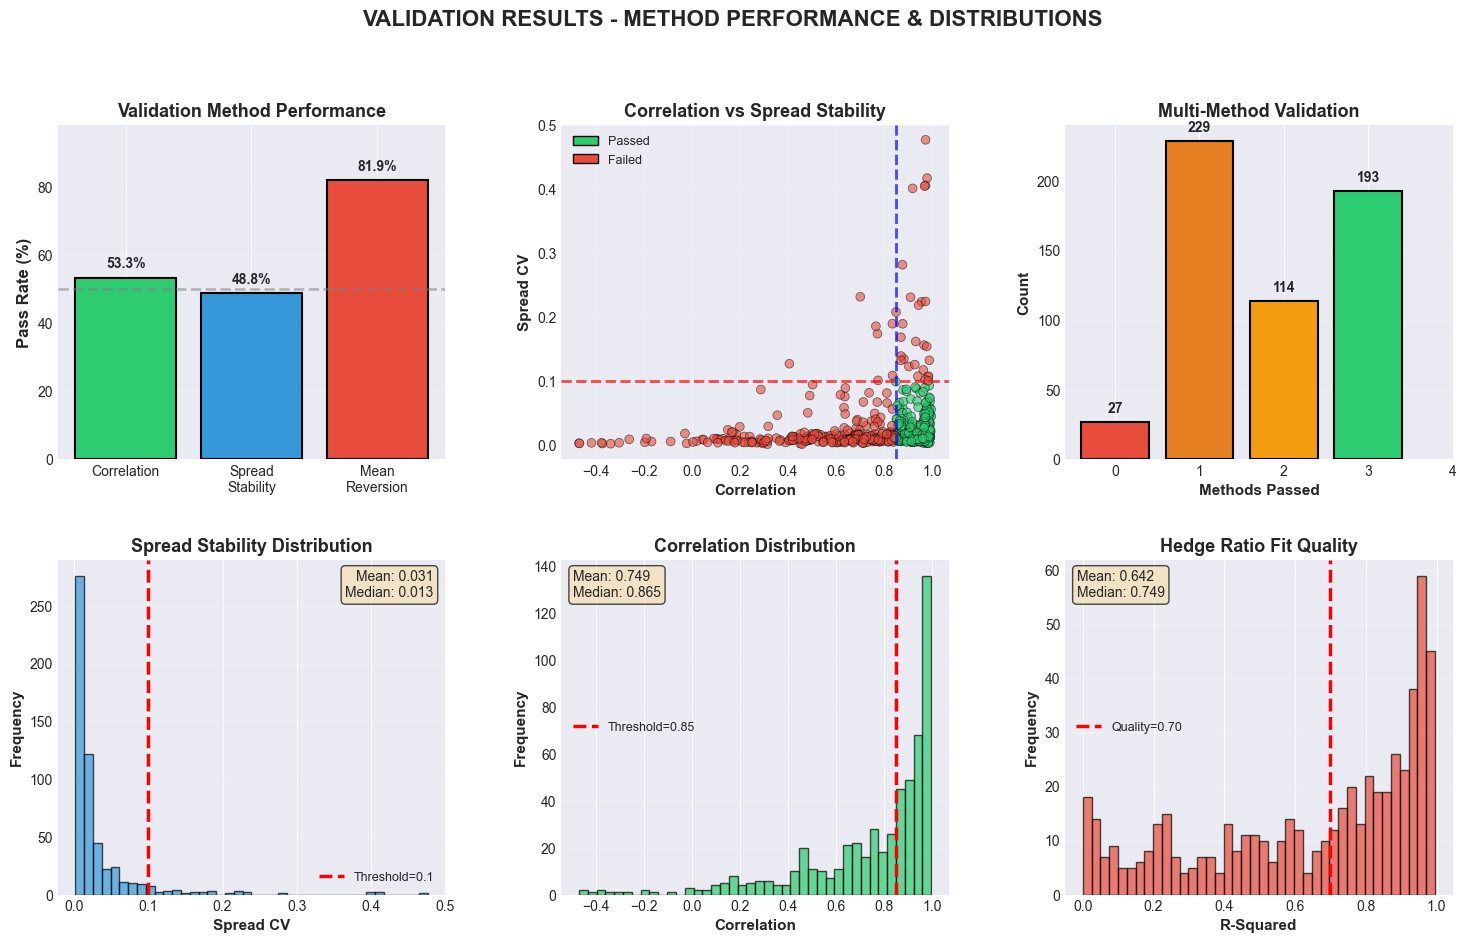

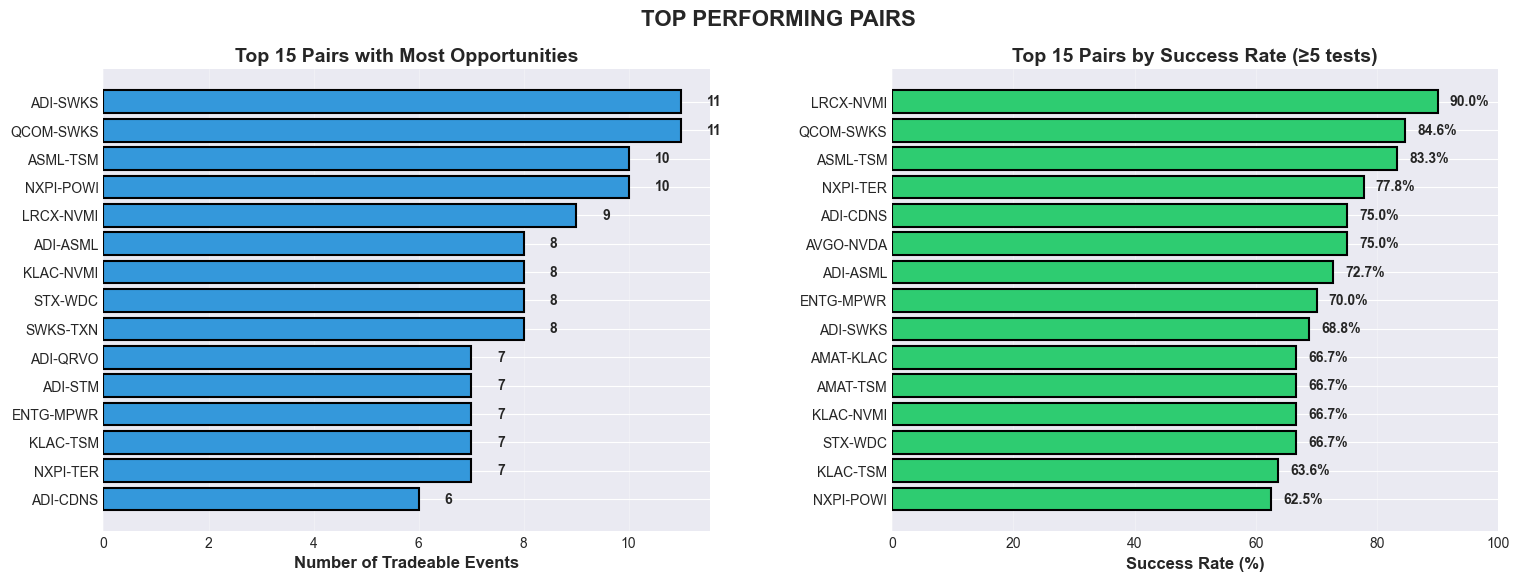


VISUALIZATIONS COMPLETE

Generated:
  • Figure 1: Method performance and statistical distributions
  • Figure 2: Top performing pairs analysis


In [20]:
# ============================================================================
# CELL 5: VISUALIZE RESULTS IN NOTEBOOK
# ============================================================================

print(f"\n{'='*80}")
print("CREATING VISUALIZATIONS")
print(f"{'='*80}")

if len(df_validation) == 0:
    print("\nNo results to visualize. Run Cell 2 first.")
else:
    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib.gridspec as gridspec
    
    # Set style for better looking plots
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # ========================================================================
    # FIGURE 1: METHOD PERFORMANCE AND DISTRIBUTIONS (3x2 grid)
    # ========================================================================
    
    fig1 = plt.figure(figsize=(18, 10))
    gs1 = gridspec.GridSpec(2, 3, figure=fig1, hspace=0.3, wspace=0.3)
    
    # Plot 1.1: Method Pass Rates
    ax1 = fig1.add_subplot(gs1[0, 0])
    
    methods = {
        'Correlation': 'corr_passed',
        'Spread\nStability': 'spread_passed',
        'Cointegration': 'coint_passed',
        'Mean\nReversion': 'mr_passed'
    }
    
    method_names = []
    pass_rates = []
    
    for name, col in methods.items():
        if col in df_validation.columns:
            total = df_validation[col].notna().sum()
            if total > 0:
                method_names.append(name)
                pass_rates.append(df_validation[col].sum() / total * 100)
    
    if len(method_names) > 0:
        colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12'][:len(method_names)]
        bars = ax1.bar(method_names, pass_rates, color=colors, edgecolor='black', linewidth=1.5)
        ax1.set_ylabel('Pass Rate (%)', fontsize=12, fontweight='bold')
        ax1.set_title('Validation Method Performance', fontsize=13, fontweight='bold')
        ax1.set_ylim([0, max(pass_rates) * 1.2 if pass_rates else 100])
        ax1.axhline(y=50, color='gray', linestyle='--', alpha=0.5, linewidth=2)
        ax1.grid(axis='y', alpha=0.3)
        
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 1.2: Correlation vs Spread CV Scatter
    ax2 = fig1.add_subplot(gs1[0, 1])
    
    if 'correlation' in df_validation.columns and 'spread_cv' in df_validation.columns:
        scatter_data = df_validation.dropna(subset=['correlation', 'spread_cv'])
        scatter_data = scatter_data[scatter_data['spread_cv'] < 0.5]  # Remove outliers
        
        if len(scatter_data) > 0:
            if 'overall_passed' in scatter_data.columns:
                colors = scatter_data['overall_passed'].map({True: '#2ecc71', False: '#e74c3c'})
                ax2.scatter(scatter_data['correlation'], scatter_data['spread_cv'],
                           c=colors, alpha=0.6, s=40, edgecolors='black', linewidth=0.5)
                
                # Add legend
                from matplotlib.patches import Patch
                legend_elements = [
                    Patch(facecolor='#2ecc71', edgecolor='black', label='Passed'),
                    Patch(facecolor='#e74c3c', edgecolor='black', label='Failed')
                ]
                ax2.legend(handles=legend_elements, loc='upper left', fontsize=9)
            else:
                ax2.scatter(scatter_data['correlation'], scatter_data['spread_cv'],
                           c='#3498db', alpha=0.6, s=40, edgecolors='black', linewidth=0.5)
            
            ax2.axhline(y=SPREAD_CV_THRESHOLD, color='red', linestyle='--', 
                       label=f'CV={SPREAD_CV_THRESHOLD}', linewidth=2, alpha=0.7)
            ax2.axvline(x=CORRELATION_THRESHOLD, color='blue', linestyle='--',
                       label=f'Corr={CORRELATION_THRESHOLD}', linewidth=2, alpha=0.7)
            
            ax2.set_xlabel('Correlation', fontsize=11, fontweight='bold')
            ax2.set_ylabel('Spread CV', fontsize=11, fontweight='bold')
            ax2.set_title('Correlation vs Spread Stability', fontsize=13, fontweight='bold')
            ax2.grid(alpha=0.3)
    
    # Plot 1.3: Methods Passed Distribution
    ax3 = fig1.add_subplot(gs1[0, 2])
    
    if 'methods_passed' in df_validation.columns:
        methods_dist = df_validation['methods_passed'].value_counts().sort_index()
        
        colors_gradient = ['#e74c3c', '#e67e22', '#f39c12', '#2ecc71', '#27ae60']
        bar_colors = [colors_gradient[min(i, len(colors_gradient)-1)] for i in methods_dist.index]
        
        bars = ax3.bar(methods_dist.index, methods_dist.values, 
                      color=bar_colors, edgecolor='black', linewidth=1.5)
        ax3.set_xlabel('Methods Passed', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Count', fontsize=11, fontweight='bold')
        ax3.set_title('Multi-Method Validation', fontsize=13, fontweight='bold')
        ax3.set_xticks(range(0, 5))
        ax3.grid(axis='y', alpha=0.3)
        
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + max(methods_dist.values)*0.02,
                    f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 1.4: Spread CV Distribution
    ax4 = fig1.add_subplot(gs1[1, 0])
    
    if 'spread_cv' in df_validation.columns:
        cv_data = df_validation['spread_cv'].dropna()
        cv_data_clean = cv_data[cv_data < 0.5]
        
        if len(cv_data_clean) > 0:
            ax4.hist(cv_data_clean, bins=40, color='#3498db', alpha=0.7, edgecolor='black')
            ax4.axvline(x=SPREAD_CV_THRESHOLD, color='red', linestyle='--', 
                       linewidth=2.5, label=f'Threshold={SPREAD_CV_THRESHOLD}')
            ax4.set_xlabel('Spread CV', fontsize=11, fontweight='bold')
            ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
            ax4.set_title('Spread Stability Distribution', fontsize=13, fontweight='bold')
            ax4.legend(fontsize=9)
            ax4.grid(axis='y', alpha=0.3)
            
            stats_text = f'Mean: {cv_data_clean.mean():.3f}\nMedian: {cv_data_clean.median():.3f}'
            ax4.text(0.97, 0.97, stats_text, transform=ax4.transAxes,
                    fontsize=10, va='top', ha='right',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    # Plot 1.5: Correlation Distribution
    ax5 = fig1.add_subplot(gs1[1, 1])
    
    if 'correlation' in df_validation.columns:
        corr_data = df_validation['correlation'].dropna()
        
        if len(corr_data) > 0:
            ax5.hist(corr_data, bins=40, color='#2ecc71', alpha=0.7, edgecolor='black')
            ax5.axvline(x=CORRELATION_THRESHOLD, color='red', linestyle='--',
                       linewidth=2.5, label=f'Threshold={CORRELATION_THRESHOLD}')
            ax5.set_xlabel('Correlation', fontsize=11, fontweight='bold')
            ax5.set_ylabel('Frequency', fontsize=11, fontweight='bold')
            ax5.set_title('Correlation Distribution', fontsize=13, fontweight='bold')
            ax5.legend(fontsize=9)
            ax5.grid(axis='y', alpha=0.3)
            
            stats_text = f'Mean: {corr_data.mean():.3f}\nMedian: {corr_data.median():.3f}'
            ax5.text(0.03, 0.97, stats_text, transform=ax5.transAxes,
                    fontsize=10, va='top', ha='left',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    # Plot 1.6: R-Squared Distribution
    ax6 = fig1.add_subplot(gs1[1, 2])
    
    if 'r_squared' in df_validation.columns:
        r2_data = df_validation['r_squared'].dropna()
        
        if len(r2_data) > 0:
            ax6.hist(r2_data, bins=40, color='#e74c3c', alpha=0.7, edgecolor='black')
            ax6.axvline(x=0.70, color='red', linestyle='--',
                       linewidth=2.5, label='Quality=0.70')
            ax6.set_xlabel('R-Squared', fontsize=11, fontweight='bold')
            ax6.set_ylabel('Frequency', fontsize=11, fontweight='bold')
            ax6.set_title('Hedge Ratio Fit Quality', fontsize=13, fontweight='bold')
            ax6.legend(fontsize=9)
            ax6.grid(axis='y', alpha=0.3)
            
            stats_text = f'Mean: {r2_data.mean():.3f}\nMedian: {r2_data.median():.3f}'
            ax6.text(0.03, 0.97, stats_text, transform=ax6.transAxes,
                    fontsize=10, va='top', ha='left',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    fig1.suptitle('VALIDATION RESULTS - METHOD PERFORMANCE & DISTRIBUTIONS', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # FIGURE 2: TOP PAIRS AND OPPORTUNITIES
    # ========================================================================
    
    if 'overall_passed' in df_validation.columns:
        tradeable_subset = df_validation[df_validation['overall_passed'] == True]
        
        if len(tradeable_subset) > 0:
            fig2 = plt.figure(figsize=(18, 6))
            gs2 = gridspec.GridSpec(1, 2, figure=fig2, hspace=0.3, wspace=0.3)
            
            # Plot 2.1: Top Pairs by Opportunity Count
            ax7 = fig2.add_subplot(gs2[0, 0])
            
            pair_counts = tradeable_subset.groupby(['ticker_a', 'ticker_b']).size().reset_index(name='count')
            top_pairs = pair_counts.nlargest(15, 'count')
            
            pair_labels = [f"{row['ticker_a']}-{row['ticker_b']}" for _, row in top_pairs.iterrows()]
            
            bars = ax7.barh(range(len(top_pairs)), top_pairs['count'], 
                           color='#3498db', edgecolor='black', linewidth=1.5)
            ax7.set_yticks(range(len(top_pairs)))
            ax7.set_yticklabels(pair_labels, fontsize=10)
            ax7.set_xlabel('Number of Tradeable Events', fontsize=12, fontweight='bold')
            ax7.set_title('Top 15 Pairs with Most Opportunities', fontsize=14, fontweight='bold')
            ax7.grid(axis='x', alpha=0.3)
            ax7.invert_yaxis()
            
            for i, bar in enumerate(bars):
                width = bar.get_width()
                ax7.text(width + 0.5, bar.get_y() + bar.get_height()/2.,
                        f'{int(width)}', ha='left', va='center', fontsize=10, fontweight='bold')
            
            # Plot 2.2: Success Rate by Pair
            ax8 = fig2.add_subplot(gs2[0, 1])
            
            # Calculate success rate for each pair
            pair_stats = df_validation.groupby(['ticker_a', 'ticker_b']).agg({
                'overall_passed': ['sum', 'count']
            }).reset_index()
            pair_stats.columns = ['ticker_a', 'ticker_b', 'opportunities', 'total']
            pair_stats['success_rate'] = pair_stats['opportunities'] / pair_stats['total'] * 100
            pair_stats = pair_stats[pair_stats['total'] >= 5]  # At least 5 tests
            top_success = pair_stats.nlargest(15, 'success_rate')
            
            pair_labels_success = [f"{row['ticker_a']}-{row['ticker_b']}" for _, row in top_success.iterrows()]
            
            bars = ax8.barh(range(len(top_success)), top_success['success_rate'], 
                           color='#2ecc71', edgecolor='black', linewidth=1.5)
            ax8.set_yticks(range(len(top_success)))
            ax8.set_yticklabels(pair_labels_success, fontsize=10)
            ax8.set_xlabel('Success Rate (%)', fontsize=12, fontweight='bold')
            ax8.set_title('Top 15 Pairs by Success Rate (≥5 tests)', fontsize=14, fontweight='bold')
            ax8.grid(axis='x', alpha=0.3)
            ax8.invert_yaxis()
            ax8.set_xlim([0, 100])
            
            for i, bar in enumerate(bars):
                width = bar.get_width()
                ax8.text(width + 2, bar.get_y() + bar.get_height()/2.,
                        f'{width:.1f}%', ha='left', va='center', fontsize=10, fontweight='bold')
            
            fig2.suptitle('TOP PERFORMING PAIRS', fontsize=16, fontweight='bold', y=0.98)
            plt.tight_layout()
            plt.show()
            
        else:
            print("\n⚠ No tradeable opportunities found - skipping pair visualization")
    
    print(f"\n{'='*80}")
    print("VISUALIZATIONS COMPLETE")
    print(f"{'='*80}")
    print(f"\nGenerated:")
    print(f"  • Figure 1: Method performance and statistical distributions")
    if 'overall_passed' in df_validation.columns and len(tradeable_subset) > 0:
        print(f"  • Figure 2: Top performing pairs analysis")


VISUALIZING TRADEABLE OPPORTUNITIES

Found 267 tradeable opportunities
Selecting top opportunities for visualization...

Visualizing 6 opportunities:
  • ASML-SNPS at 2025-03-26 17:30:00+00:00 (CV: 0.0026, Corr: 0.986)
  • MCHP-NXPI at 2025-03-20 16:30:00+00:00 (CV: 0.0027, Corr: 0.977)
  • ADI-STM at 2025-03-20 15:30:00+00:00 (CV: 0.0029, Corr: 0.977)
  • ADI-SWKS at 2025-03-13 17:30:00+00:00 (CV: 0.0861, Corr: 0.880)
  • ADI-SWKS at 2025-03-13 19:30:00+00:00 (CV: 0.0354, Corr: 0.899)
  • ADI-SWKS at 2025-03-14 15:30:00+00:00 (CV: 0.0073, Corr: 0.944)

GENERATING DETAILED VISUALIZATIONS



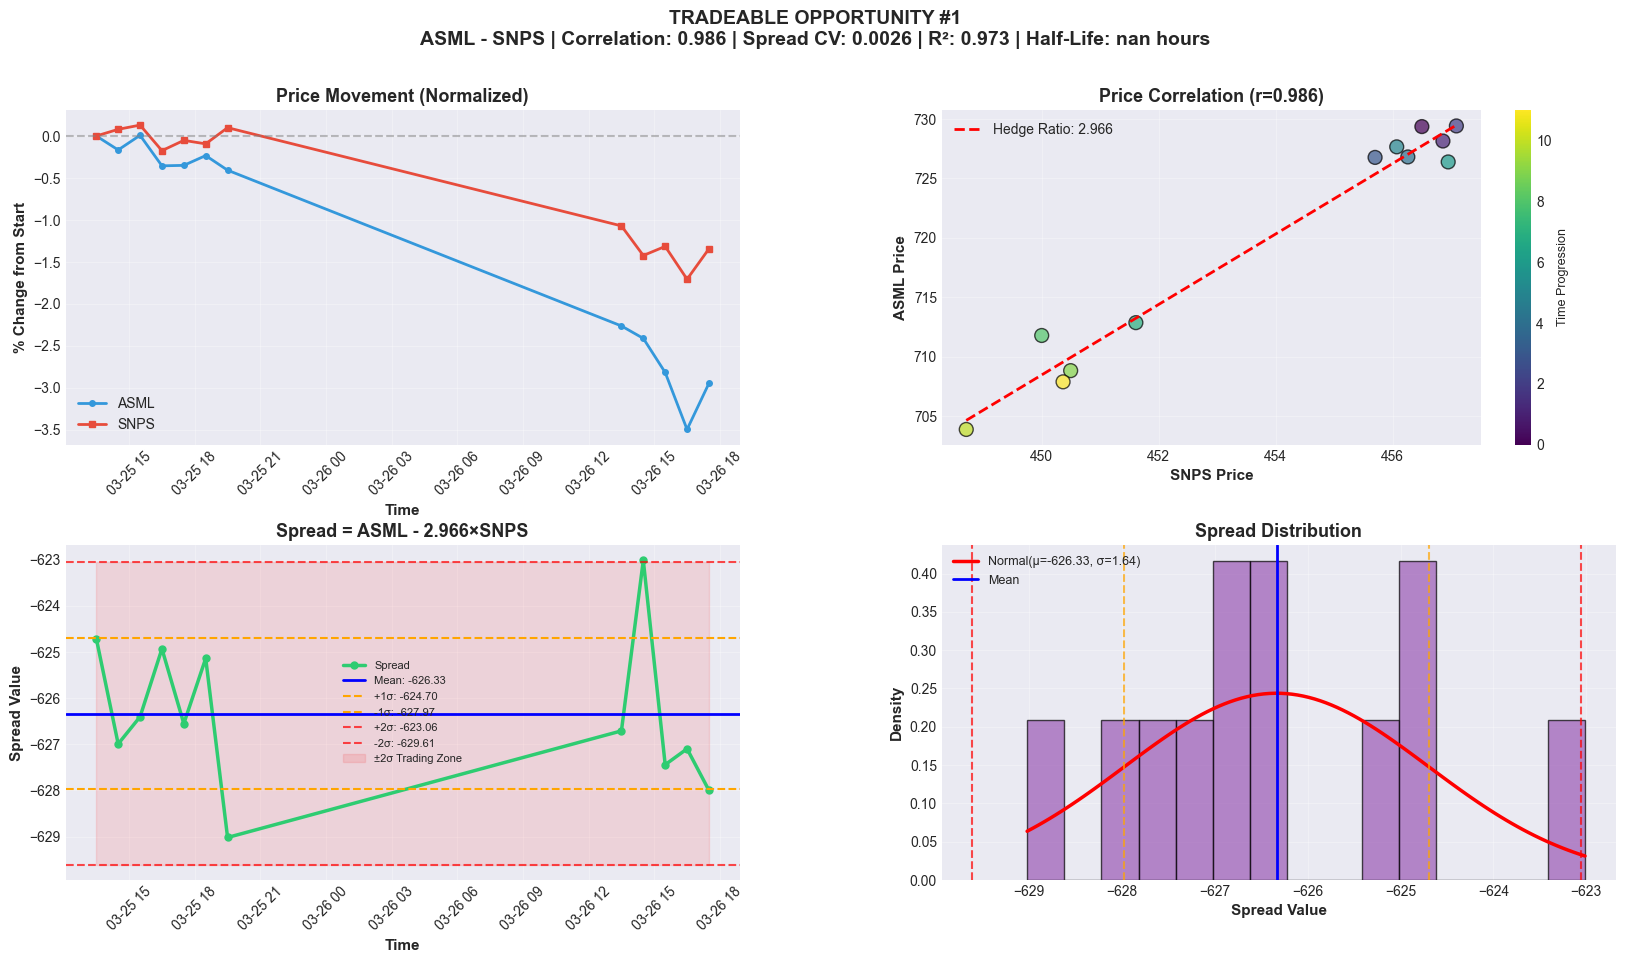


OPPORTUNITY #1: ASML-SNPS
Timestamp: 2025-03-26 17:30:00+00:00
Window: 30 hours (12 observations)

Statistics:
  Correlation: 0.9863
  Spread CV: 0.0026 (lower = better)
  R-Squared: 0.9728

Spread Metrics:
  Mean: -626.3340
  Std Dev: 1.6370
  Current: -627.9984
  Z-Score: -1.02σ

Trading Setup:
  Hedge Ratio: 2.9662
  Strategy: ASML - 2.9662 × SNPS
  ⚠️  Spread at -1.02σ (approaching signal)

Price Levels at Detection:
  ASML: $707.87
  SNPS: $450.36



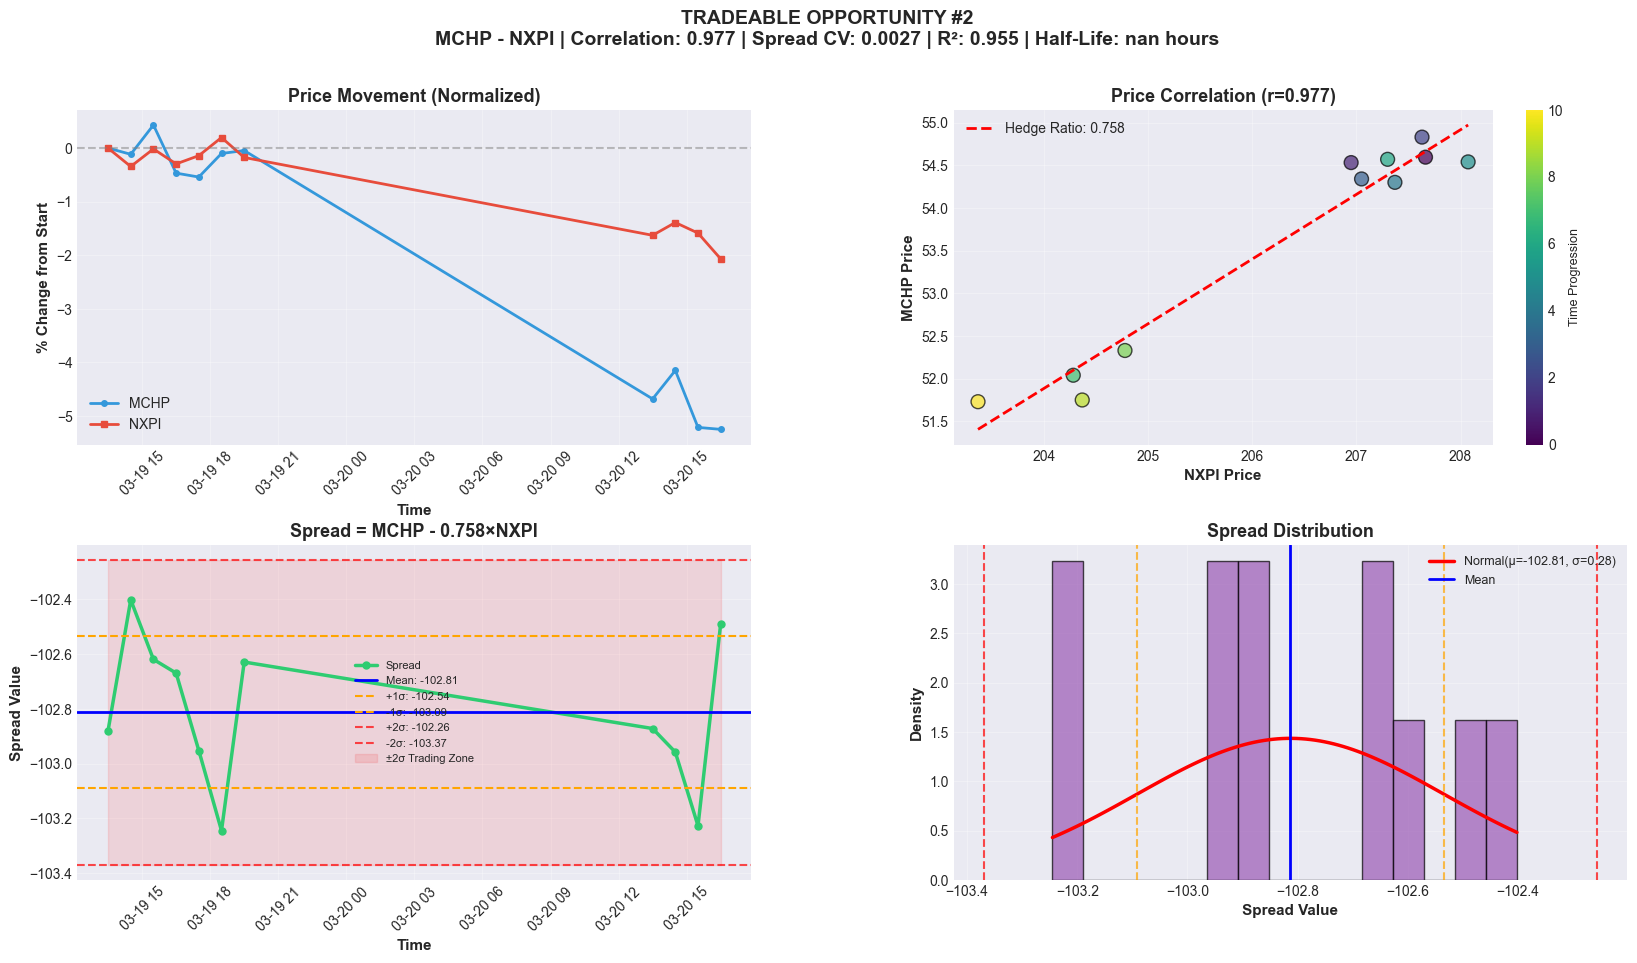


OPPORTUNITY #2: MCHP-NXPI
Timestamp: 2025-03-20 16:30:00+00:00
Window: 30 hours (11 observations)

Statistics:
  Correlation: 0.9773
  Spread CV: 0.0027 (lower = better)
  R-Squared: 0.9551

Spread Metrics:
  Mean: -102.8132
  Std Dev: 0.2779
  Current: -102.4891
  Z-Score: 1.17σ

Trading Setup:
  Hedge Ratio: 0.7583
  Strategy: MCHP - 0.7583 × NXPI
  ⚠️  Spread at 1.17σ (approaching signal)

Price Levels at Detection:
  MCHP: $51.73
  NXPI: $203.37



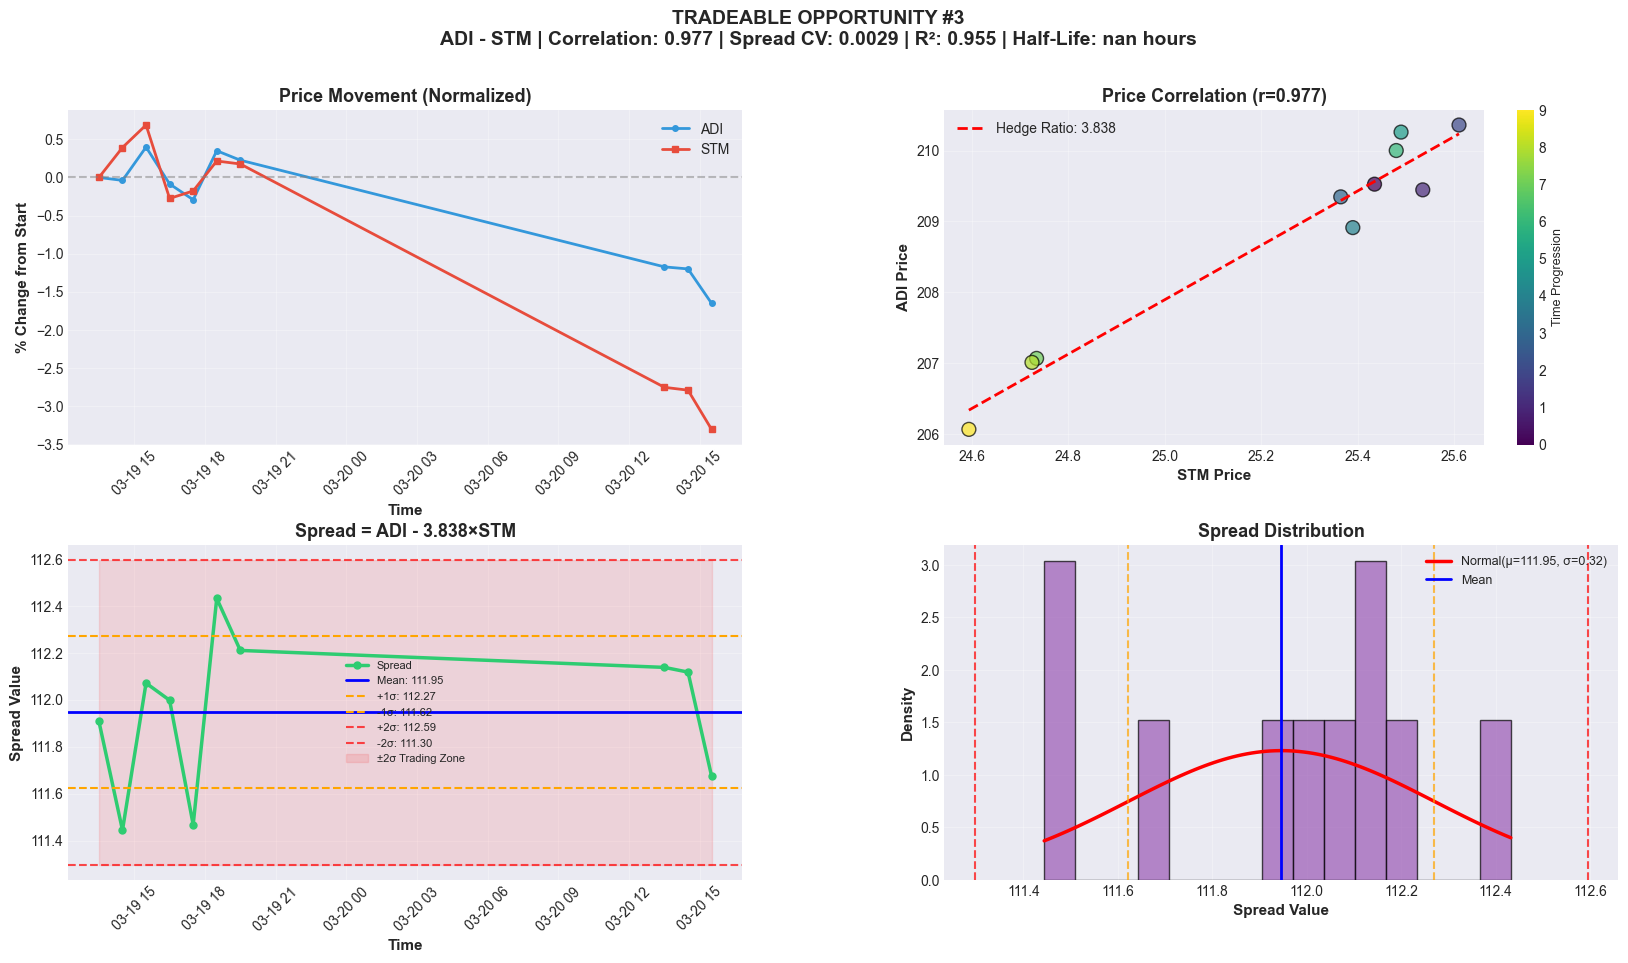


OPPORTUNITY #3: ADI-STM
Timestamp: 2025-03-20 15:30:00+00:00
Window: 30 hours (10 observations)

Statistics:
  Correlation: 0.9772
  Spread CV: 0.0029 (lower = better)
  R-Squared: 0.9548

Spread Metrics:
  Mean: 111.9461
  Std Dev: 0.3242
  Current: 111.6748
  Z-Score: -0.84σ

Trading Setup:
  Hedge Ratio: 3.8379
  Strategy: ADI - 3.8379 × STM
  ✓ Spread near mean (-0.84σ) - wait for signal

Price Levels at Detection:
  ADI: $206.07
  STM: $24.59



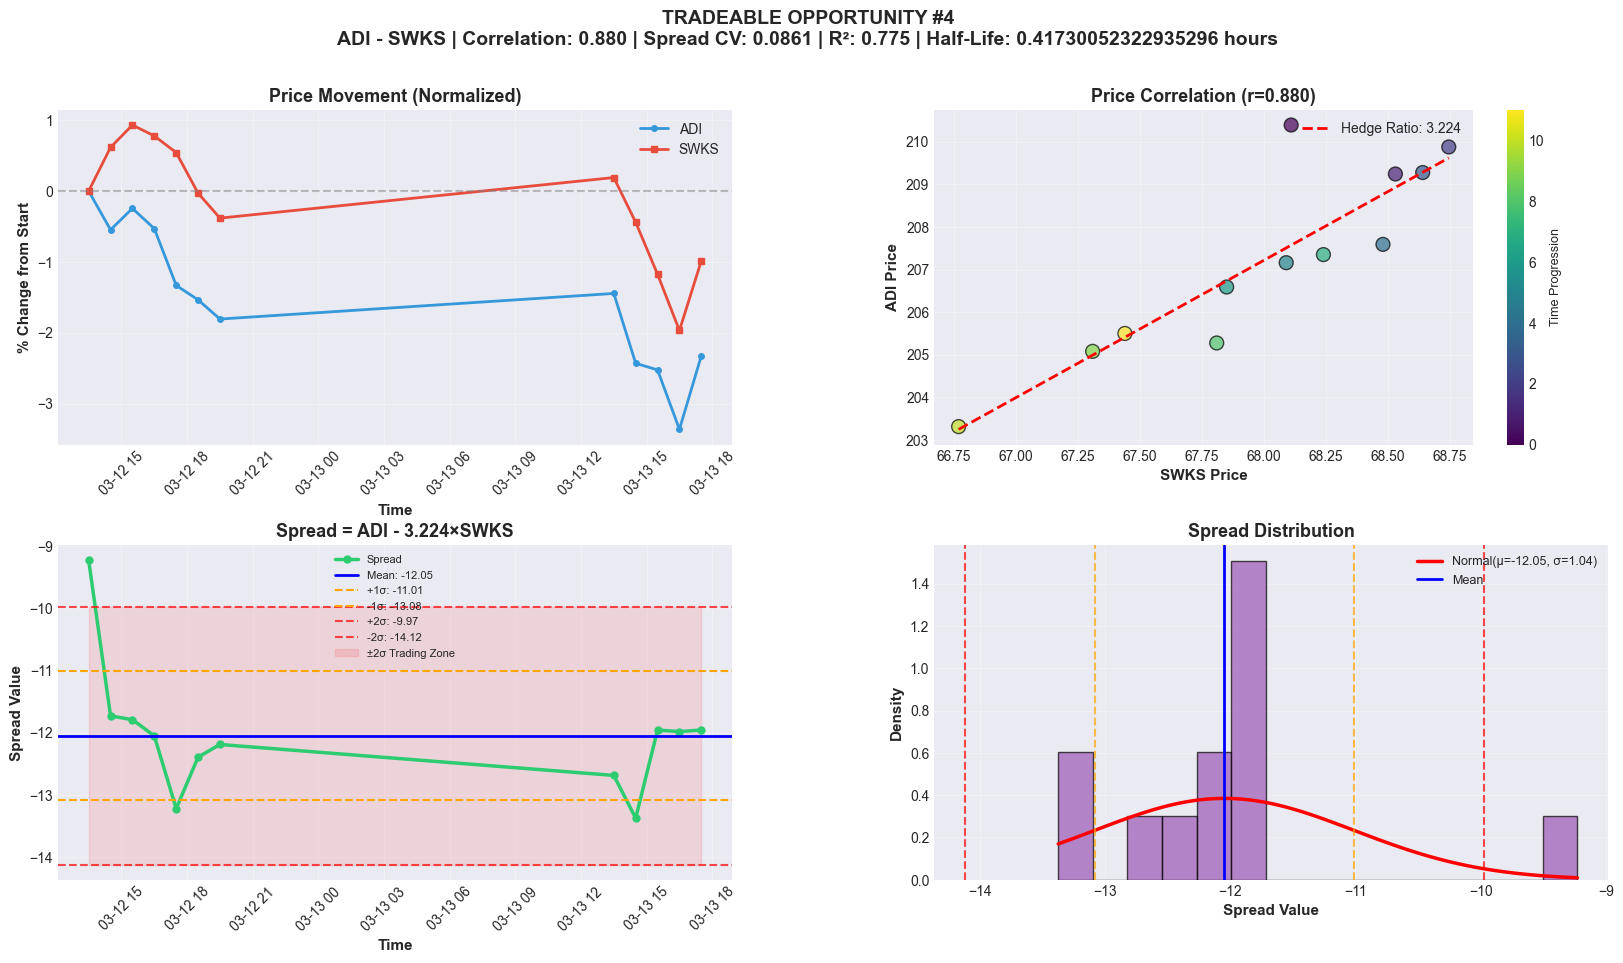


OPPORTUNITY #4: ADI-SWKS
Timestamp: 2025-03-13 17:30:00+00:00
Window: 30 hours (12 observations)

Statistics:
  Correlation: 0.8803
  Spread CV: 0.0861 (lower = better)
  R-Squared: 0.7749
  Half-Life: 0.42 hours

Spread Metrics:
  Mean: -12.0460
  Std Dev: 1.0366
  Current: -11.9565
  Z-Score: 0.09σ

Trading Setup:
  Hedge Ratio: 3.2244
  Strategy: ADI - 3.2244 × SWKS
  ✓ Spread near mean (0.09σ) - wait for signal

Price Levels at Detection:
  ADI: $205.50
  SWKS: $67.44



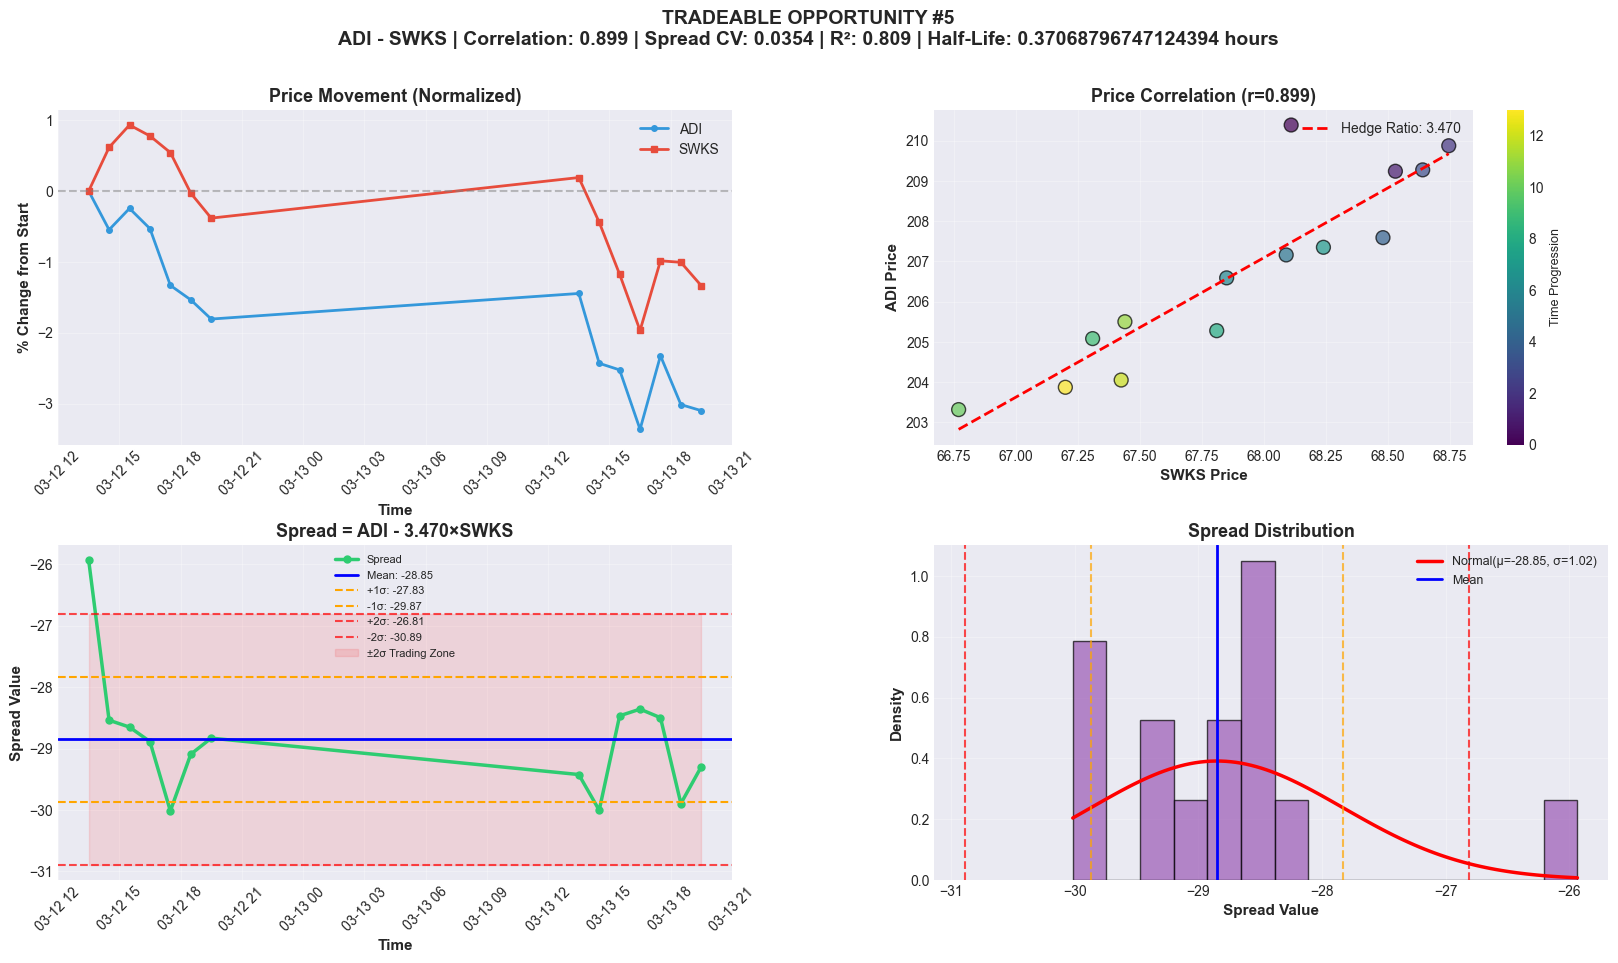


OPPORTUNITY #5: ADI-SWKS
Timestamp: 2025-03-13 19:30:00+00:00
Window: 30 hours (14 observations)

Statistics:
  Correlation: 0.8993
  Spread CV: 0.0354 (lower = better)
  R-Squared: 0.8087
  Half-Life: 0.37 hours

Spread Metrics:
  Mean: -28.8495
  Std Dev: 1.0204
  Current: -29.2953
  Z-Score: -0.44σ

Trading Setup:
  Hedge Ratio: 3.4697
  Strategy: ADI - 3.4697 × SWKS
  ✓ Spread near mean (-0.44σ) - wait for signal

Price Levels at Detection:
  ADI: $203.87
  SWKS: $67.20



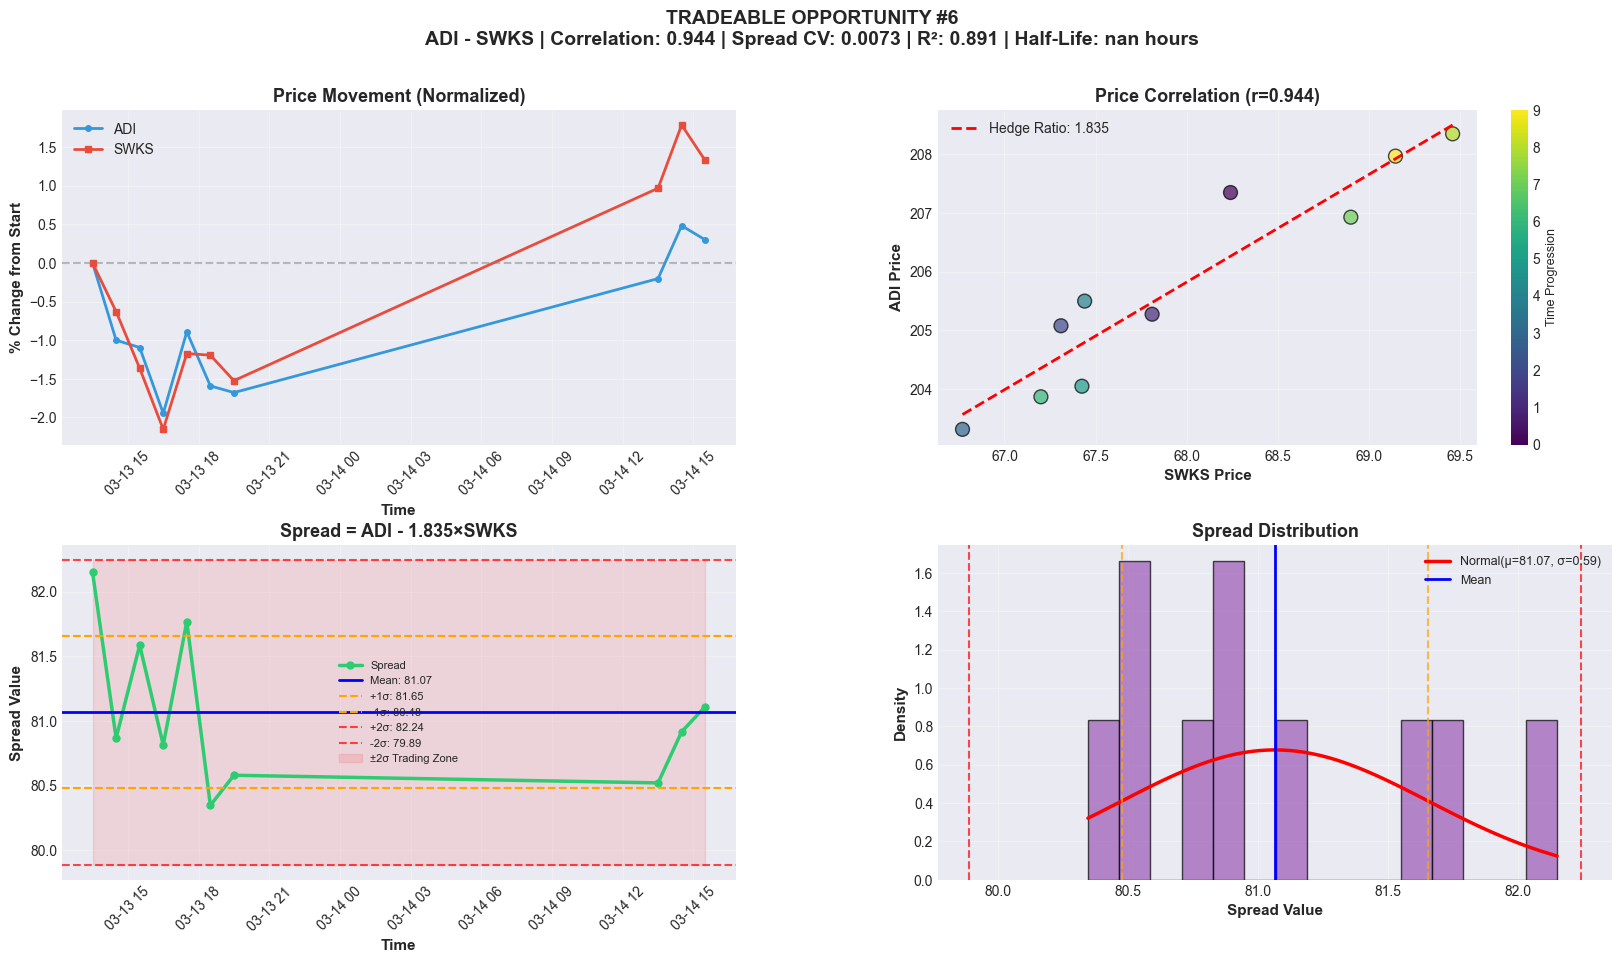


OPPORTUNITY #6: ADI-SWKS
Timestamp: 2025-03-14 15:30:00+00:00
Window: 30 hours (10 observations)

Statistics:
  Correlation: 0.9441
  Spread CV: 0.0073 (lower = better)
  R-Squared: 0.8912

Spread Metrics:
  Mean: 81.0652
  Std Dev: 0.5892
  Current: 81.1099
  Z-Score: 0.08σ

Trading Setup:
  Hedge Ratio: 1.8347
  Strategy: ADI - 1.8347 × SWKS
  ✓ Spread near mean (0.08σ) - wait for signal

Price Levels at Detection:
  ADI: $207.97
  SWKS: $69.14


VISUALIZATION COMPLETE

Generated 6 detailed opportunity visualizations

Each visualization shows:
  • Panel 1: Normalized price movements (% change)
  • Panel 2: Price correlation scatter with hedge ratio
  • Panel 3: Spread over time with ±1σ and ±2σ bands
  • Panel 4: Spread distribution vs normal curve

Trading signals based on Z-score:
  • |Z| > 2.0σ → Strong entry signal
  • |Z| > 1.5σ → Moderate entry signal
  • |Z| < 1.0σ → Wait for signal


In [21]:
# ============================================================================
# CELL 6: VISUALIZE INDIVIDUAL TRADEABLE OPPORTUNITIES
# ============================================================================

print(f"\n{'='*80}")
print("VISUALIZING TRADEABLE OPPORTUNITIES")
print(f"{'='*80}")

if 'df_validation' not in locals() or len(df_validation) == 0:
    print("\nNo validation results found. Run Cell 2 first.")
else:
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import numpy as np
    
    # Get tradeable opportunities
    tradeable = df_validation[df_validation['overall_passed'] == True].copy()
    
    if len(tradeable) == 0:
        print("\nNo tradeable opportunities to visualize.")
    else:
        print(f"\nFound {len(tradeable)} tradeable opportunities")
        print(f"Selecting top opportunities for visualization...\n")
        
        # ====================================================================
        # SELECT OPPORTUNITIES TO VISUALIZE
        # ====================================================================
        
        # Sort by quality (lowest spread CV = best quality)
        tradeable_sorted = tradeable.sort_values('spread_cv')
        
        # Get different quality tiers
        excellent = tradeable_sorted.head(3)  # Top 3 by spread CV
        good = tradeable_sorted.iloc[len(tradeable)//2:len(tradeable)//2 + 3]  # Middle 3
        
        # Also get some from top pairs
        top_pairs = tradeable.groupby(['ticker_a', 'ticker_b']).size().reset_index(name='count')
        top_pair = top_pairs.nlargest(1, 'count').iloc[0]
        from_top_pair = tradeable[
            (tradeable['ticker_a'] == top_pair['ticker_a']) & 
            (tradeable['ticker_b'] == top_pair['ticker_b'])
        ].head(3)
        
        # Combine selections (remove duplicates)
        selected = pd.concat([excellent, from_top_pair]).drop_duplicates()
        selected = selected.head(6)  # Max 6 opportunities
        
        print(f"Visualizing {len(selected)} opportunities:")
        for idx, row in selected.iterrows():
            print(f"  • {row['ticker_a']}-{row['ticker_b']} at {row['timestamp']} " 
                  f"(CV: {row['spread_cv']:.4f}, Corr: {row['correlation']:.3f})")
        
        # ====================================================================
        # VISUALIZATION FUNCTION
        # ====================================================================
        
        def visualize_opportunity(opportunity_row, ts_df, fig_num):
            """
            Create detailed 4-panel visualization for a single opportunity.
            """
            ticker_a = opportunity_row['ticker_a']
            ticker_b = opportunity_row['ticker_b']
            timestamp = opportunity_row['timestamp']
            window_hours = opportunity_row['window_hours']
            
            # Extract price data
            start_time = timestamp - pd.Timedelta(hours=window_hours)
            end_time = timestamp
            
            # Get prices using the same function from validation
            ticker_a_data = ts_df.xs(ticker_a, level='Ticker')
            ticker_b_data = ts_df.xs(ticker_b, level='Ticker')
            
            mask_a = (ticker_a_data.index >= start_time) & (ticker_a_data.index <= end_time)
            mask_b = (ticker_b_data.index >= start_time) & (ticker_b_data.index <= end_time)
            
            prices_a = ticker_a_data.loc[mask_a, 'Price']
            prices_b = ticker_b_data.loc[mask_b, 'Price']
            
            # Align prices
            common_idx = prices_a.index.intersection(prices_b.index)
            prices_a = prices_a.loc[common_idx]
            prices_b = prices_b.loc[common_idx]
            
            if len(prices_a) < 3:
                print(f"\n⚠ Skipping {ticker_a}-{ticker_b}: insufficient data")
                return
            
            # Calculate hedge ratio and spread
            from sklearn.linear_model import LinearRegression
            X = prices_b.values.reshape(-1, 1)
            y = prices_a.values
            model = LinearRegression()
            model.fit(X, y)
            hedge_ratio = model.coef_[0]
            
            spread = prices_a - hedge_ratio * prices_b
            spread_mean = spread.mean()
            spread_std = spread.std()
            
            # Normalize prices for comparison
            norm_a = (prices_a / prices_a.iloc[0] - 1) * 100  # % change
            norm_b = (prices_b / prices_b.iloc[0] - 1) * 100
            
            # Create figure
            fig = plt.figure(figsize=(20, 10))
            gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
            
            # ================================================================
            # PANEL 1: Normalized Price Movement (Top Left)
            # ================================================================
            ax1 = fig.add_subplot(gs[0, 0])
            
            ax1.plot(common_idx, norm_a, label=ticker_a, color='#3498db', 
                    linewidth=2, marker='o', markersize=4)
            ax1.plot(common_idx, norm_b, label=ticker_b, color='#e74c3c', 
                    linewidth=2, marker='s', markersize=4)
            
            ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            ax1.set_xlabel('Time', fontsize=11, fontweight='bold')
            ax1.set_ylabel('% Change from Start', fontsize=11, fontweight='bold')
            ax1.set_title('Price Movement (Normalized)', fontsize=13, fontweight='bold')
            ax1.legend(fontsize=10, loc='best')
            ax1.grid(alpha=0.3)
            
            # Rotate x-axis labels
            ax1.tick_params(axis='x', rotation=45)
            
            # ================================================================
            # PANEL 2: Correlation Scatter (Top Right)
            # ================================================================
            ax2 = fig.add_subplot(gs[0, 1])
            
            ax2.scatter(prices_b, prices_a, alpha=0.7, s=100, 
                       c=range(len(prices_a)), cmap='viridis', edgecolors='black')
            
            # Add regression line
            x_line = np.array([prices_b.min(), prices_b.max()])
            y_line = hedge_ratio * x_line + model.intercept_
            ax2.plot(x_line, y_line, 'r--', linewidth=2, label=f'Hedge Ratio: {hedge_ratio:.3f}')
            
            ax2.set_xlabel(f'{ticker_b} Price', fontsize=11, fontweight='bold')
            ax2.set_ylabel(f'{ticker_a} Price', fontsize=11, fontweight='bold')
            ax2.set_title(f'Price Correlation (r={opportunity_row["correlation"]:.3f})', 
                         fontsize=13, fontweight='bold')
            ax2.legend(fontsize=10)
            ax2.grid(alpha=0.3)
            
            # Add colorbar to show time progression
            sm = plt.cm.ScalarMappable(cmap='viridis', 
                                       norm=plt.Normalize(vmin=0, vmax=len(prices_a)-1))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax2)
            cbar.set_label('Time Progression', fontsize=9)
            
            # ================================================================
            # PANEL 3: Spread Over Time (Bottom Left)
            # ================================================================
            ax3 = fig.add_subplot(gs[1, 0])
            
            ax3.plot(common_idx, spread, color='#2ecc71', linewidth=2.5, 
                    marker='o', markersize=5, label='Spread')
            
            # Add mean and standard deviation bands
            ax3.axhline(y=spread_mean, color='blue', linestyle='-', 
                       linewidth=2, label=f'Mean: {spread_mean:.2f}')
            ax3.axhline(y=spread_mean + spread_std, color='orange', linestyle='--', 
                       linewidth=1.5, label=f'+1σ: {spread_mean + spread_std:.2f}')
            ax3.axhline(y=spread_mean - spread_std, color='orange', linestyle='--', 
                       linewidth=1.5, label=f'-1σ: {spread_mean - spread_std:.2f}')
            ax3.axhline(y=spread_mean + 2*spread_std, color='red', linestyle='--', 
                       linewidth=1.5, alpha=0.7, label=f'+2σ: {spread_mean + 2*spread_std:.2f}')
            ax3.axhline(y=spread_mean - 2*spread_std, color='red', linestyle='--', 
                       linewidth=1.5, alpha=0.7, label=f'-2σ: {spread_mean - 2*spread_std:.2f}')
            
            # Shade the ±2σ region
            ax3.fill_between(common_idx, 
                            spread_mean - 2*spread_std, 
                            spread_mean + 2*spread_std,
                            alpha=0.1, color='red', label='±2σ Trading Zone')
            
            ax3.set_xlabel('Time', fontsize=11, fontweight='bold')
            ax3.set_ylabel('Spread Value', fontsize=11, fontweight='bold')
            ax3.set_title(f'Spread = {ticker_a} - {hedge_ratio:.3f}×{ticker_b}', 
                         fontsize=13, fontweight='bold')
            ax3.legend(fontsize=8, loc='best')
            ax3.grid(alpha=0.3)
            ax3.tick_params(axis='x', rotation=45)
            
            # ================================================================
            # PANEL 4: Spread Distribution & Mean Reversion (Bottom Right)
            # ================================================================
            ax4 = fig.add_subplot(gs[1, 1])
            
            # Histogram of spread values
            n, bins, patches = ax4.hist(spread, bins=15, color='#9b59b6', 
                                       alpha=0.7, edgecolor='black', density=True)
            
            # Overlay normal distribution
            from scipy.stats import norm
            x_norm = np.linspace(spread.min(), spread.max(), 100)
            y_norm = norm.pdf(x_norm, spread_mean, spread_std)
            ax4.plot(x_norm, y_norm, 'r-', linewidth=2.5, 
                    label=f'Normal(μ={spread_mean:.2f}, σ={spread_std:.2f})')
            
            # Add mean line
            ax4.axvline(x=spread_mean, color='blue', linestyle='-', 
                       linewidth=2, label='Mean')
            
            # Add ±1σ and ±2σ lines
            ax4.axvline(x=spread_mean + spread_std, color='orange', 
                       linestyle='--', linewidth=1.5, alpha=0.7)
            ax4.axvline(x=spread_mean - spread_std, color='orange', 
                       linestyle='--', linewidth=1.5, alpha=0.7)
            ax4.axvline(x=spread_mean + 2*spread_std, color='red', 
                       linestyle='--', linewidth=1.5, alpha=0.7)
            ax4.axvline(x=spread_mean - 2*spread_std, color='red', 
                       linestyle='--', linewidth=1.5, alpha=0.7)
            
            ax4.set_xlabel('Spread Value', fontsize=11, fontweight='bold')
            ax4.set_ylabel('Density', fontsize=11, fontweight='bold')
            ax4.set_title('Spread Distribution', fontsize=13, fontweight='bold')
            ax4.legend(fontsize=9)
            ax4.grid(alpha=0.3)
            
            # ================================================================
            # Main Title with Metrics
            # ================================================================
            metrics_text = (
                f"{ticker_a} - {ticker_b} | "
                f"Correlation: {opportunity_row['correlation']:.3f} | "
                f"Spread CV: {opportunity_row['spread_cv']:.4f} | "
                f"R²: {opportunity_row['r_squared']:.3f} | "
                f"Half-Life: {opportunity_row.get('half_life_hours', 'N/A')} hours"
            )
            
            if pd.notna(opportunity_row.get('half_life_hours')):
                metrics_text = metrics_text.replace('N/A', f"{opportunity_row['half_life_hours']:.1f}")
            
            fig.suptitle(
                f"TRADEABLE OPPORTUNITY #{fig_num}\n{metrics_text}",
                fontsize=14, fontweight='bold', y=0.98
            )
            
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()
            
            # Print trading signals
            print(f"\n{'='*60}")
            print(f"OPPORTUNITY #{fig_num}: {ticker_a}-{ticker_b}")
            print(f"{'='*60}")
            print(f"Timestamp: {timestamp}")
            print(f"Window: {window_hours} hours ({len(prices_a)} observations)")
            print(f"\nStatistics:")
            print(f"  Correlation: {opportunity_row['correlation']:.4f}")
            print(f"  Spread CV: {opportunity_row['spread_cv']:.4f} (lower = better)")
            print(f"  R-Squared: {opportunity_row['r_squared']:.4f}")
            if pd.notna(opportunity_row.get('half_life_hours')):
                print(f"  Half-Life: {opportunity_row['half_life_hours']:.2f} hours")
            
            print(f"\nSpread Metrics:")
            print(f"  Mean: {spread_mean:.4f}")
            print(f"  Std Dev: {spread_std:.4f}")
            print(f"  Current: {spread.iloc[-1]:.4f}")
            print(f"  Z-Score: {(spread.iloc[-1] - spread_mean) / spread_std:.2f}σ")
            
            print(f"\nTrading Setup:")
            print(f"  Hedge Ratio: {hedge_ratio:.4f}")
            print(f"  Strategy: {ticker_a} - {hedge_ratio:.4f} × {ticker_b}")
            
            # Entry signals
            current_z = (spread.iloc[-1] - spread_mean) / spread_std
            if abs(current_z) > 2:
                if current_z > 2:
                    print(f"  📊 ENTRY SIGNAL: Spread at +{current_z:.2f}σ")
                    print(f"     → SHORT the spread (Short {ticker_a}, Long {ticker_b})")
                else:
                    print(f"  📊 ENTRY SIGNAL: Spread at {current_z:.2f}σ")
                    print(f"     → LONG the spread (Long {ticker_a}, Short {ticker_b})")
            elif abs(current_z) > 1:
                print(f"  ⚠️  Spread at {current_z:.2f}σ (approaching signal)")
            else:
                print(f"  ✓ Spread near mean ({current_z:.2f}σ) - wait for signal")
            
            print(f"\nPrice Levels at Detection:")
            print(f"  {ticker_a}: ${prices_a.iloc[-1]:.2f}")
            print(f"  {ticker_b}: ${prices_b.iloc[-1]:.2f}")
            print(f"{'='*60}\n")
        
        # ====================================================================
        # VISUALIZE SELECTED OPPORTUNITIES
        # ====================================================================
        
        print(f"\n{'='*80}")
        print("GENERATING DETAILED VISUALIZATIONS")
        print(f"{'='*80}\n")
        
        for fig_num, (idx, opportunity) in enumerate(selected.iterrows(), 1):
            try:
                visualize_opportunity(opportunity, ts_df, fig_num)
            except Exception as e:
                print(f"\n⚠ Error visualizing opportunity {fig_num}: {str(e)}")
                continue
        
        print(f"\n{'='*80}")
        print("VISUALIZATION COMPLETE")
        print(f"{'='*80}")
        print(f"\nGenerated {len(selected)} detailed opportunity visualizations")
        print(f"\nEach visualization shows:")
        print(f"  • Panel 1: Normalized price movements (% change)")
        print(f"  • Panel 2: Price correlation scatter with hedge ratio")
        print(f"  • Panel 3: Spread over time with ±1σ and ±2σ bands")
        print(f"  • Panel 4: Spread distribution vs normal curve")
        print(f"\nTrading signals based on Z-score:")
        print(f"  • |Z| > 2.0σ → Strong entry signal")
        print(f"  • |Z| > 1.5σ → Moderate entry signal")
        print(f"  • |Z| < 1.0σ → Wait for signal")